In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as coma
from sklearn.feature_extraction.text import TfidfVectorizer as tfidfv
import scipy

In [3]:
#### import df
# from ..Data.pull_df_from_mongo import main as pull_df
# from ..Data.pull_df_from_mongo import *

import sys
sys.path.append("..")
import Data.pull_df_from_mongo as pull_df
#### translate as copy
#### get column names for styles
#### tts. identify rows for training - known of that style, known of NOT that style

In [768]:
df = pull_df.main()

In [769]:
df_copy = df.copy()

In [770]:
df = df_copy.copy()

In [773]:
def prep_df_rfc_model(df,keep_cols,dummies):
    df_test = df[keep_cols]
    df_test = pd.get_dummies(dummies)
    return df_test

def rfc_for_style(df,style_col,col_indecies):
    df = df_usable(df,style_col,col_indecies)
    Y = df.pop(style_col)
    X = df
    X_train, X_test, Y_train, Y_test = tts(X,Y)
    rfc = RandomForestClassifier(n_estimators=200,max_features=int(len(X.columns)**(0.5)+1))
    rfc.fit(X_train,Y_train)
    con_matrix(rfc,X_test,Y_test)
    return rfc

def transform_df(df):
    transform_df = df_pipeline(df)
    return transform_df

def df_pipeline(df):
    ## drop cols
    drop_cols = ["_highlightResult",'_id','cleanSpecs','colors','diffbotUri','dimensions',
                 "hidden","in_page_variations","isbn","mpn","offerPriceDetails","overriddenStyles",
                 "pageUrl","prefixCode","priceRange","primaryImage","private", "processedCategory",
                 "processedImages","productId","productOrigin","projects","otherImages",
                 "regularPrice","regularPriceDetails","resolvedPageUrl","saveAmount","saveAmountDetails",
                 "shippingAmount","showrooms","sku","specs","tradePrice","type","upc","url","variations",
                 "visibleVerified"]
    df.drop(drop_cols,axis=1,inplace=True)
    
    ## extract cols 
    col_name, grab_cols = 'normalizedDimensions', unique_dict_keys(df,'normalizedDimensions',{})['normalizedDimensions']
    df = df_extract_cols(df,col_name,grab_cols)
    df.drop(col_name,axis=1,inplace=True)
    
    col_name, grab_cols = 'hierarchicalCategories', unique_dict_keys(df,'hierarchicalCategories',{})['hierarchicalCategories']
    df = df_extract_cols(df,col_name,grab_cols)
    df.drop(col_name,axis=1,inplace=True)
    
    col_name, grab_cols = 'predominantColorsResult', unique_dict_keys(df,'predominantColorsResult',{})['predominantColorsResult']
    df = df_extract_cols(df,col_name,grab_cols)
    df.drop(col_name,axis=1,inplace=True)    
    
    df = category_fix(df)
    
    
    ## dummies for styles
    df = df_extract_styles(df)
    
    ## extract url from dictionary
    df = df_extract_url(df)
    
    ## clean text
    df = clean_text(df)
    
    
    ## clean column duplicates
    df = clean_cols(df)
    
    ## remove column name spaces
    df = df_remove_col_name_spaces(df)

    return df
    
        
def df_extract_cols(df,col_name,grab_cols):
    col_prefix = {"_highlightResult":"HR","normalizedDimensions":"dim","hierarchicalCategories":"Categories",
                 "predominantColorsResult":"color"}
    lst = list(df[col_name])
    for col in grab_cols:
        
        load_col = []
        for item in lst:
            try:
                if col in item.iterkeys():
                    if type(item[col]) == list:
                        item[col] = "".join(item[col])
                    load_col.append(item[col])
                else:
                    load_col.append(0)
            except:
                load_col.append(0)
        df["{}_{}".format(col_prefix[col_name],col)] = load_col
    return df

def df_extract_styles(df):

    check = df['_styles']

    categories = set()

    for category_group in set(check):
    
        try:
            lst = str(category_group).split(",")
            categories.update(lst)
        except:
            continue
    
    
    for category in list(categories):
        col = []
    
        for row in check:
            if str(category) in str(row):
                col.append(1)
            else:
                col.append(0)

        df['{}_style'.format(str(category))] = col
    
    return df

def clean_cols(df):
    df['Mid-Century_style'] = df['Mid Century_style'] + df['Mid-Century_style']
    df['Coastal_style'] = df['Coastal _style'] + df['Coastal_style']
    df['Country_style'] = df['Country _style'] + df['Country_style']
    df['styles'] = df['_styles']
    comb = ['Mid Century_style','Coastal _style',"Country_style","_styles"]
    df.drop(comb,axis=1,inplace=True)

    return df

def category_fix(df):
    check = list(df['Categories_lvl0'])
    df["Categories_lvl1"] = [i if i!=0 else check[idx] for idx,i in enumerate(df['Categories_lvl1'])]
    check = list(df['Categories_lvl1'])
    df["Categories_lvl2"] = [i if i!=0 else check[idx] for idx,i in enumerate(df['Categories_lvl2'])]
    
    check = list(df['Categories_lvl2'])
    df["Categories_lvl3"] = [i if i!=0 else check[idx] for idx,i in enumerate(df['Categories_lvl3'])]
    return df

def unique_dict_keys(df,col,uniques):
    check = df[col]
    uniques[col] = set()
    for i in check:
        if i in [check[0],{},np.nan]:
            continue
        else:
            for dim,val in i.iteritems():
                uniques[col].add(dim)
    return uniques

def df_extract_url(df):
    col = []
    for row in df['images']:
        try:
            col.append(row[0]['url'])
        except:
            col.append(0)
    df['images'] = col
    return df

def clean_text(df):
    df["new_text"] = df['text'].fillna('')
    return df

def df_remove_col_name_spaces(df):
    cols = list(df.columns)
    for idx,col in enumerate(cols):
        if " " in str(col):
            cols[idx] = str(col).replace(" ","")
        else:
            cols[idx] = str(col)
    df.columns = cols
    return df

def con_matrix(model,X_test,Y_test):
    y_predict = model.predict(X_test)
    conmatrix = coma(Y_test,y_predict)
    tn,fp,fn,tp = conmatrix.ravel()
    print conmatrix
    print "tn: ",tn,"fp: ",fp,"fn: ",fn,"tp: ",tp
    precision = tp / float(tp+fp)
    recall = tp / float(tp+fn)
    accuracy = (tp + tn) / float(tp + tn + fp + fn)
    print "Precision is: ", precision
    print "Recall is: ", recall
    print "Accuracy is: ", accuracy

def df_usable(df_input,style_col,col_indecies):
    dropped_rows = []
    df_filtered = df_input.copy()
    for idx,row in enumerate(df_input):
        tags = sum(df_filtered[style_cols])
        if row[col_indecies[style_col]] >=1:
            continue
        elif tags <= 1:
            dropped_rows.append(idx)
            df_filtered.drop([idx],axis=0,inplace=True)
        elif tags == 2:
            dropped_rows.append(idx)
            df_filtered.drop([idx],axis=0,inplace=True)
    return df_filtered, dropped_rows

def style_col_index(df,style_cols):
    col_indecies = {}
    for idx,i in enumerate(list(df.columns)):
        col_indecies[i] = idx
    return col_indecies

def get_rfc_models(df,keep_cols,dummies,style_cols):
    df = prep_df_rfc_model(df,keep_cols,dummies)
    return df

In [774]:
df = transform_df(df)

In [320]:
def check_see(col,n=5):
    check = set(df[col])
    c = 0
    for i in check:
        if c == n:
            break
        else:
            print i
        c+=1
from collections import Counter
def check_counter(col):
    check = df[col]
    counter = Counter(check)
    print "Total uniques:  ",len(list(counter.iterkeys()))
    print counter

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186626 entries, 0 to 186625
Data columns (total 82 columns):
brand                     21554 non-null object
directCategory            178158 non-null object
images                    186626 non-null object
objectID                  186626 non-null object
priceLevel                128823 non-null object
site                      184116 non-null object
styles                    42266 non-null object
text                      165945 non-null object
title                     186393 non-null object
dim_diameter              186626 non-null float64
dim_arm_width             186626 non-null float64
dim_diam                  186626 non-null float64
dim_projection            186626 non-null float64
dim_wide                  186626 non-null float64
dim_back_rail_height      186626 non-null int64
dim_depth                 186626 non-null float64
dim_deep                  186626 non-null float64
dim_height                186626 non-null float64
di

In [336]:
df[use_cols].describe()

,color_blue,color_brown,color_gray,color_purple,color_yellow,color_pink,color_green,color_teal,color_orange,color_black,color_white,color_red
count,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000,186626.000000
mean,2.948129,19.525746,9.423981,1.128889,4.084671,0.153203,1.114976,3.081794,1.129449,2.059528,42.268173,0.727391
std,10.184239,25.575242,18.718434,5.496445,12.262904,2.366557,5.445349,10.703146,6.958816,7.666620,36.913100,5.067839
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000
75%,0.000000,29.300000,9.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.100000,0.000000
max,100.100000,100.400000,100.200000,100.200000,100.200000,100.000000,100.200000,100.300000,100.000000,100.000000,100.000000,100.100000


In [863]:
import transform_df as ld

In [864]:
df = ld.main()

set(['Mid-Century', 'Rustic', 'Arts and Crafts', 'Geometric', 'Rococo', 'Folk Art', 'nan', 'Regency', 'Neoclassical', 'Stripe', 'Floral', 'Coastal ', 'Mid Century', 'Country ', 'Transitional', 'Solid', 'Country', 'Tribal', 'Traditional', 'Victorian', 'Art Nouveau', 'Hollywood Regency', 'Baroque', 'Woven', 'Prints', 'Industrial', 'Classic', 'Abstract', 'Modern', 'Contemporary', 'Transitional ', 'Gothic', 'Asian', 'Coastal', 'Southwestern', 'Art Deco', 'Louis XVI'])


In [865]:
list(df.columns)

['brand',
 'directCategory',
 'images',
 'objectID',
 'priceLevel',
 'showrooms',
 'site',
 'styles',
 'text',
 'title',
 'dim_diameter',
 'dim_arm_width',
 'dim_diam',
 'dim_projection',
 'dim_wide',
 'dim_back_rail_height',
 'dim_depth',
 'dim_deep',
 'dim_height',
 'dim_width',
 'dim_length',
 'dim_overall_height',
 'dim_footboard_height',
 'dim_tall',
 'dim_seat_height',
 'dim_seat_width',
 'dim_arm_height',
 'dim_seat_depth',
 'dim_armheight',
 'dim_backplate',
 'Categories_lvl2',
 'Categories_lvl3',
 'Categories_lvl0',
 'Categories_lvl1',
 'color_blue',
 'color_brown',
 'color_gray',
 'color_purple',
 'color_yellow',
 'color_pink',
 'color_green',
 'color_teal',
 'color_orange',
 'color_black',
 'color_white',
 'color_red',
 'Mid-Century_style',
 'Rustic_style',
 'ArtsandCrafts_style',
 'Geometric_style',
 'Rococo_style',
 'FolkArt_style',
 'Regency_style',
 'Neoclassical_style',
 'Stripe_style',
 'Floral_style',
 'Country_style',
 'Solid_style',
 'Tribal_style',
 'Traditional_st

In [869]:
check = df["showrooms"]
col = []
for idx,i in enumerate(check):
    if i in [[],np.nan]:
        col.append(0)
    else:
        lst = []
        for group in i:
            lst.append("id_{}".format(group["id"]))
        col.append(lst)
df['showroom_ids'] = col


showrm_ids = set()

check = df['showroom_ids']
c=0
for showroom_ids in check:
    if showroom_ids == 0:
        c+=1
        continue
    else:
        for i in showroom_ids:
            showrm_ids.add(i)

for i in list(showrm_ids):
    col = []
    for idx in check:
        if idx == 0:
            col.append(0)
        elif i in idx:
            col.append(1)
        else:
            col.append(0)
    df[i] = col

for i in list(df.columns):
    if "id_" in i:
        use_cols.append(i)

In [846]:
style_cols = ['Mid-Century_style',
 'Rustic_style',
 'ArtsandCrafts_style',
 'Geometric_style',
 'Rococo_style',
 'FolkArt_style',
 'Regency_style',
 'Neoclassical_style',
 'Stripe_style',
 'Floral_style',
 'Country_style',
 'Transitional_style',
 'Solid_style',
 'Tribal_style',
 'Traditional_style',
 'Victorian_style',
 'ArtNouveau_style',
 'HollywoodRegency_style',
 'Baroque_style',
 'Woven_style',
 'Prints_style',
 'Industrial_style',
 'Classic_style',
 'Abstract_style',
 'Modern_style',
 'Contemporary_style',
 'Gothic_style',
 'Asian_style',
 'Coastal_style',
 'Southwestern_style',
 'ArtDeco_style',
 'LouisXVI_style']

for style in style_cols:
    try:
        print style, ":  ", sum(df[style])
    except:
        print style, "  fail"

Mid-Century_style :   8259
Rustic_style :   10572
ArtsandCrafts_style :   5856
Geometric_style :   17
Rococo_style :   2
FolkArt_style :   5
Regency_style :   2653
Neoclassical_style :   3
Stripe_style :   11
Floral_style :   1
Country_style :   48
Transitional_style :   23148
Solid_style :   131
Tribal_style :   1
Traditional_style :   18724
Victorian_style :   1
ArtNouveau_style :   4
HollywoodRegency_style :   2652
Baroque_style :   1
Woven_style :   1
Prints_style :   14
Industrial_style :   11512
Classic_style :   8
Abstract_style :   12
Modern_style :   14480
Contemporary_style :   30731
Gothic_style :   1
Asian_style :   6634
Coastal_style :   9705
Southwestern_style :   1
ArtDeco_style :   191
LouisXVI_style :   5


In [867]:
use_cols = ['brand',
 'directCategory',
 'priceLevel',
 'site',
 'text',
 'title',
 'dim_diameter',
 'dim_arm_width',
 'dim_diam',
 'dim_projection',
 'dim_wide',
 'dim_back_rail_height',
 'dim_depth',
 'dim_deep',
 'dim_height',
 'dim_width',
 'dim_length',
 'dim_overall_height',
 'dim_footboard_height',
 'dim_tall',
 'dim_seat_height',
 'dim_seat_width',
 'dim_arm_height',
 'dim_seat_depth',
 'dim_armheight',
 'dim_backplate',
 'Categories_lvl2',
 'Categories_lvl3',
 'Categories_lvl0',
 'Categories_lvl1']

use_cols = ['color_blue',
 'color_brown',
 'color_gray',
 'color_purple',
 'color_yellow',
 'color_pink',
 'color_green',
 'color_teal',
 'color_orange',
 'color_black',
 'color_white',
 'color_red']

In [871]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.sparse import hstack



def df_for_fit(filtered_df,style_col,use_cols):
    vector = TfidfVectorizer(stop_words='english')
    vector = vectorizer.fit_transform(filtered_df['new_text'])
    labels = vectorizer.get_feature_names()
    y = list(filtered_df[style_col])
    X = scipy.sparse.hstack((vector,filtered_df[use_cols].to_sparse()))
    return X,y,labels

def graph_it(model,labels,use_cols,log_classifier=False):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    x_labels = list(labels)
    for i in use_cols:
        x_labels.append(i)
    n_features = 25
    features_df = pd.DataFrame(model.feature_importances_,index=x_labels).nlargest(n_features,0)
    features_df.columns = ['scores']
    print features_df
    scores = features_df['scores']
    chart_label = list(features_df.index)
    num_cols = range(1,n_features+1)
    plt.bar(num_cols,list(scores),align='center')
    plt.xticks(num_cols,chart_label,rotation='vertical')
    plt.show()

def filter_df_for_style(df,style_cols,style_col):
    df['target'] = df[style_col]
    df['style_tot'] = 0
    for style in style_cols:
        df['style_sum'] = df[style] + df["style_tot"]
        df['style_tot'] = df['style_sum']
        df.drop('style_sum',axis=1,inplace=True)
    filtered_df = df[(df['target'] != 0) | (df['style_tot'] >= 1)]
    return filtered_df

In [873]:
def test_rfc(filtered_df,style_col,use_cols):
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)
    X_train, X_test, Y_train, Y_test = tts(X,y)
    rfc = RandomForestClassifier(n_estimators=1000)
    rfc.fit(X_train,Y_train)
    print style_col
    con_matrix(rfc,X_test,Y_test)
    graph_it(rfc,labels,use_cols)

def run_rfcs(df,style_cols,use_cols):
    for style_col in style_cols:
        filtered_df = filter_df_for_style(df,style_cols,style_col)
        tot = filtered_df['target'].sum()
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            test_rfc(filtered_df,style_col,use_cols)
            print ""


    

### Results when running max_features, with colors, 200 trees

Mid-Century_style
[[8381  104]
 [ 658 1376]]
tn:  8381 fp:  104 fn:  658 tp:  1376
Precision is:  0.92972972973
Recall is:  0.676499508358
Accuracy is:  0.92755965396
                scores
color_brown   0.029709
color_white   0.026964
vinyl         0.021736
color_gray    0.019765
specs         0.016334
hemp          0.015177
color_black   0.012223
color_yellow  0.012031
chair         0.011812
color_teal    0.011205
planter       0.010770
manila        0.009926
leather       0.009872
color_blue    0.009415
silk          0.008485
cor           0.008244
grass         0.007751
japanese      0.006722
color_purple  0.006675
limited       0.006328
dining        0.006028
discontinued  0.005850
mirror        0.005699
color_green   0.005476
m2            0.004948


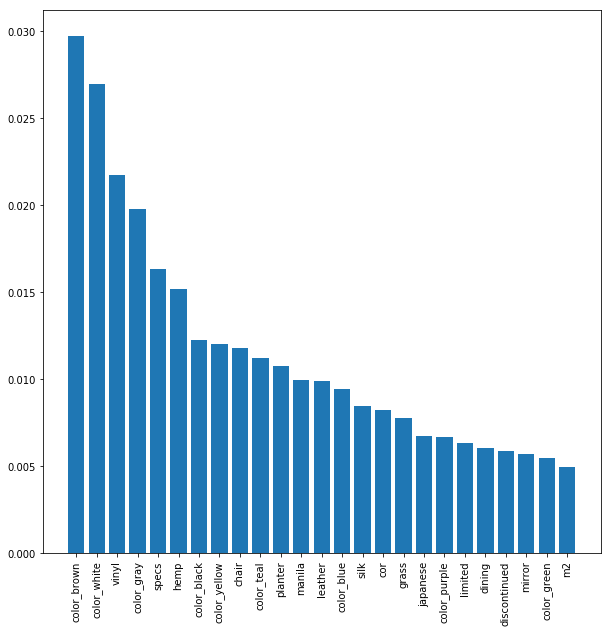


Rustic_style
[[7774  179]
 [ 821 1745]]
tn:  7774 fp:  179 fn:  821 tp:  1745
Precision is:  0.906964656965
Recall is:  0.680046765394
Accuracy is:  0.904933929081
                scores
color_brown   0.028973
color_white   0.026897
chair         0.025267
color_gray    0.023364
color_teal    0.018869
color_yellow  0.015522
color_blue    0.015382
ii            0.013327
color_black   0.011667
color_green   0.011023
specs         0.010855
set           0.009681
color_purple  0.008539
ceramic       0.007140
wooden        0.006992
mirror        0.006730
table         0.006466
planter       0.005961
metal         0.005604
dining        0.004915
glass         0.004909
leather       0.004890
mc            0.004746
small         0.004555
iii           0.004530


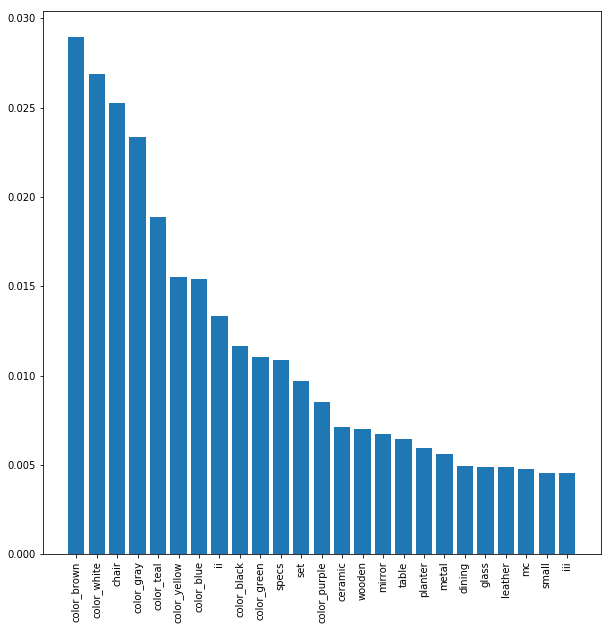


ArtsandCrafts_style
[[9040   37]
 [ 392 1050]]
tn:  9040 fp:  37 fn:  392 tp:  1050
Precision is:  0.965961361546
Recall is:  0.728155339806
Accuracy is:  0.959216655576
                scores
color_white   0.039888
vinyl         0.033901
color_brown   0.029204
color_yellow  0.024301
color_gray    0.020868
hemp          0.019783
color_teal    0.016481
planter       0.015812
manila        0.015773
chair         0.015319
color_blue    0.011637
color_green   0.011331
grass         0.010077
silk          0.008840
japanese      0.008833
discontinued  0.008798
stock         0.008339
limited       0.007955
color_purple  0.007301
color_black   0.007016
specs         0.006931
glass         0.006479
orchids       0.006269
linen         0.005394
raffia        0.005353


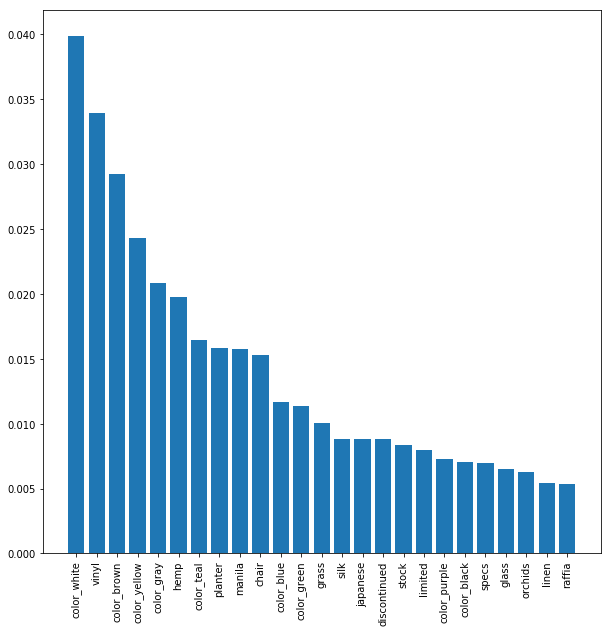


Geometric_style too small

Rococo_style too small

FolkArt_style too small

Regency_style
[[9863   17]
 [ 317  322]]
tn:  9863 fp:  17 fn:  317 tp:  322
Precision is:  0.949852507375
Recall is:  0.503912363067
Accuracy is:  0.968247932313
                scores
color_yellow  0.037260
color_brown   0.033188
planter       0.031751
color_gray    0.026334
color_white   0.025268
color_teal    0.019004
color_green   0.017218
orchids       0.016291
color_blue    0.013751
glass         0.012602
bracket       0.011941
vase          0.009397
color_purple  0.008914
color_black   0.008773
chair         0.007574
fern          0.006676
ceramic       0.006484
vanda         0.006285
ball          0.006073
grass         0.005502
peonies       0.005439
hydrangeas    0.004852
mixed         0.004797
yellow        0.004732
finial        0.004597


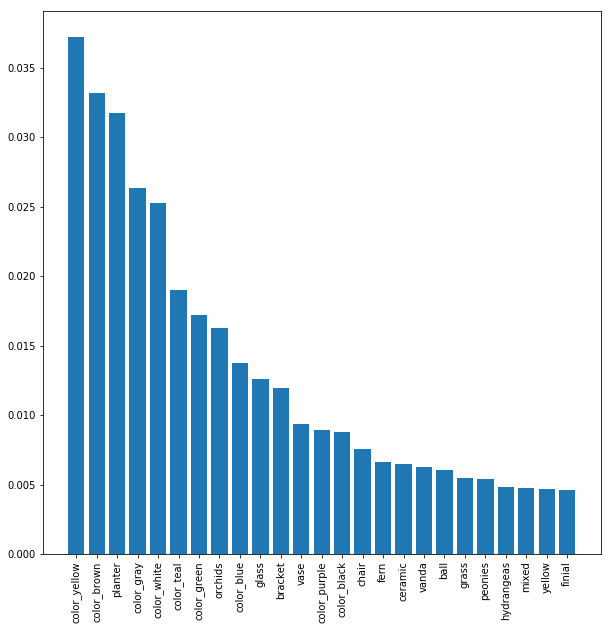


Neoclassical_style too small

Stripe_style too small

Floral_style too small

Country_style too small

Transitional_style
[[3891  883]
 [ 295 5450]]
tn:  3891 fp:  883 fn:  295 tp:  5450
Precision is:  0.860571609032
Recall is:  0.94865100087
Accuracy is:  0.888012168457
                scores
color_white   0.036783
color_brown   0.023477
specs         0.017949
color_gray    0.016526
century       0.015077
color_yellow  0.012085
max           0.012046
chair         0.011870
leather       0.011058
color_black   0.009865
shape         0.009190
color_teal    0.009020
time          0.008903
polyurethane  0.008787
suitable      0.008670
comfortable   0.008554
color_blue    0.008462
set           0.008004
structure     0.007460
12            0.007435
backrest      0.006543
steel         0.006460
commercial    0.006442
color_purple  0.006404
ppm           0.006274


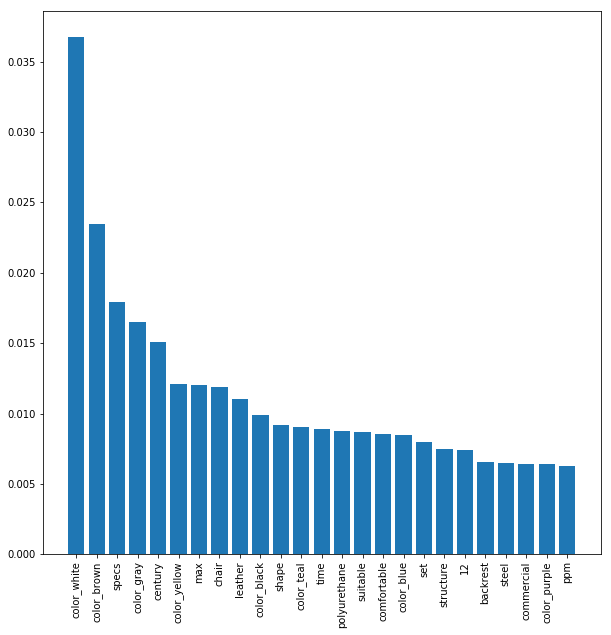


Solid_style too small

Tribal_style too small

Traditional_style
[[5170  621]
 [ 620 4108]]
tn:  5170 fp:  621 fn:  620 tp:  4108
Precision is:  0.868682596743
Recall is:  0.868866328257
Accuracy is:  0.882023005989
                scores
color_white   0.046364
color_brown   0.037400
color_gray    0.024492
color_yellow  0.017066
chair         0.015227
color_teal    0.015185
color_blue    0.013310
specs         0.012749
color_black   0.010936
color_purple  0.008825
color_green   0.007981
mirror        0.007827
ii            0.007760
dining        0.006889
strength      0.006625
comfortable   0.006473
set           0.005821
century       0.005614
seat          0.005486
lounge        0.005291
30            0.005247
upholstered   0.005221
shape         0.005102
backrest      0.005011
table         0.004763


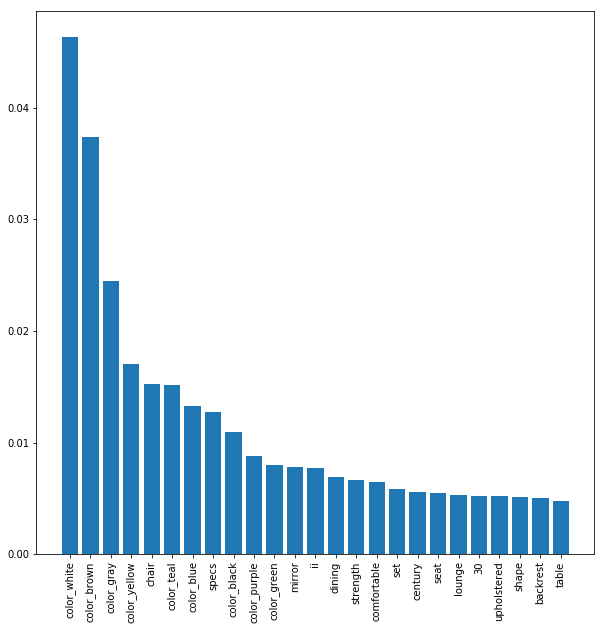


Victorian_style too small

ArtNouveau_style too small

HollywoodRegency_style
[[9804   15]
 [ 367  333]]
tn:  9804 fp:  15 fn:  367 tp:  333
Precision is:  0.956896551724
Recall is:  0.475714285714
Accuracy is:  0.963684760909
                scores
color_yellow  0.035875
color_brown   0.031754
planter       0.031300
color_gray    0.025658
color_white   0.025036
color_teal    0.019290
color_green   0.016675
orchids       0.013353
color_blue    0.013108
bracket       0.012274
vase          0.011785
glass         0.010879
color_black   0.009888
color_purple  0.008426
vanda         0.008027
ball          0.007353
chair         0.007133
fern          0.007015
hydrangeas    0.006314
ceramic       0.006178
peonies       0.005654
yellow        0.005388
color_orange  0.005292
finial        0.004855
pole          0.004769


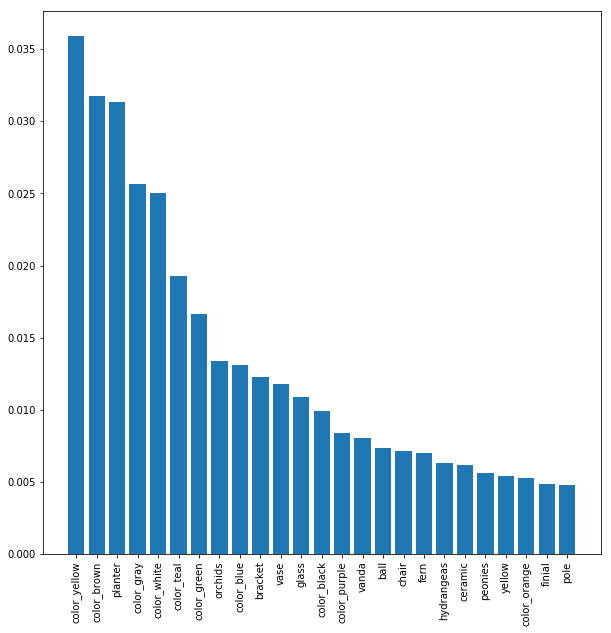


Baroque_style too small

Woven_style too small

Prints_style too small

Industrial_style
[[7453  171]
 [ 541 2354]]
tn:  7453 fp:  171 fn:  541 tp:  2354
Precision is:  0.932277227723
Recall is:  0.813126079447
Accuracy is:  0.932312957505
                scores
chair         0.041443
color_white   0.034493
color_brown   0.031187
color_teal    0.021434
color_gray    0.020214
color_yellow  0.019333
color_blue    0.015834
color_black   0.015666
ii            0.014556
specs         0.013751
color_green   0.011683
vinyl         0.011457
color_purple  0.009623
hemp          0.007464
mirror        0.007333
ceramic       0.006281
set           0.006264
manila        0.006073
lounge        0.005681
dining        0.005585
white         0.005537
metal         0.005487
sofa          0.005468
wooden        0.005409
planter       0.005133


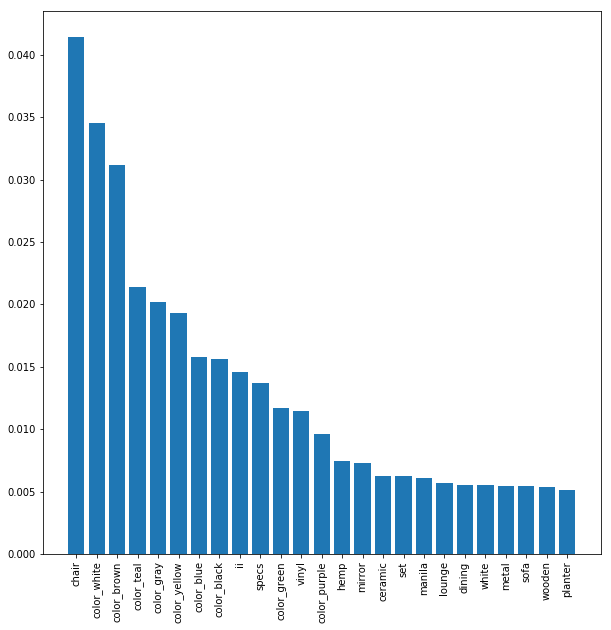


Classic_style too small

Abstract_style too small

Modern_style
[[6593  269]
 [ 581 3076]]
tn:  6593 fp:  269 fn:  581 tp:  3076
Precision is:  0.919581464873
Recall is:  0.841126606508
Accuracy is:  0.919193839719
                scores
color_white   0.029629
color_brown   0.026914
max           0.021236
color_gray    0.019630
color_yellow  0.018641
lead          0.017092
strength      0.017045
weight        0.015191
frame         0.013784
chair         0.013639
color_teal    0.013050
shape         0.011608
color_black   0.010984
min           0.010686
steel         0.010634
color_blue    0.010507
wool          0.010365
commercial    0.010272
color_green   0.010116
designed      0.009147
injecting     0.008879
color_red     0.008728
flexibility   0.008550
ozkaynak      0.008319
color_purple  0.007970


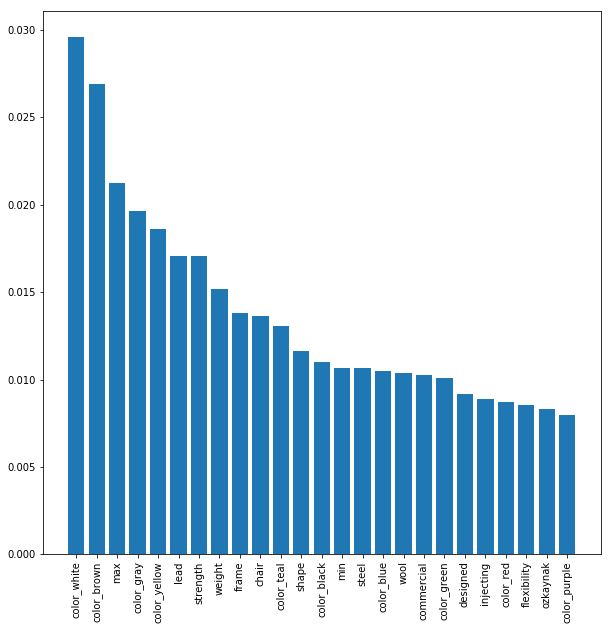


Contemporary_style
[[1960  926]
 [ 254 7379]]
tn:  1960 fp:  926 fn:  254 tp:  7379
Precision is:  0.88850090307
Recall is:  0.966723437705
Accuracy is:  0.887822036315
                scores
color_white   0.030031
color_brown   0.028080
chair         0.024182
color_gray    0.019860
specs         0.018729
century       0.017502
color_yellow  0.013964
leather       0.012521
color_black   0.010969
color_teal    0.010168
color_blue    0.009756
bradington    0.009025
young         0.009009
color_purple  0.007424
color_green   0.006197
set           0.005952
inches        0.005915
mirror        0.005856
dining        0.005178
seat          0.004822
loveseat      0.004801
lounge        0.004703
height        0.004671
weight        0.004654
chairs        0.004295


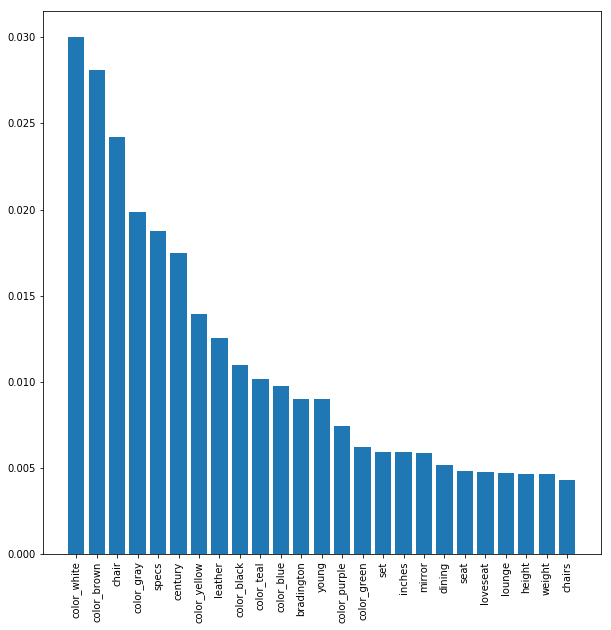


Gothic_style too small

Asian_style
[[8821   43]
 [ 407 1248]]
tn:  8821 fp:  43 fn:  407 tp:  1248
Precision is:  0.966692486445
Recall is:  0.754078549849
Accuracy is:  0.957220268086
                scores
vinyl         0.027308
color_white   0.027210
color_brown   0.024294
color_gray    0.018236
hemp          0.017578
planter       0.015049
manila        0.014546
color_yellow  0.014391
ceramic       0.014362
chair         0.012210
white         0.010619
grass         0.009932
japanese      0.009238
color_blue    0.009175
silk          0.009134
color_teal    0.008352
discontinued  0.008098
stock         0.007644
mirror        0.007348
color_black   0.006841
specs         0.006320
glass         0.006139
limited       0.005898
color_purple  0.005693
color_green   0.005559


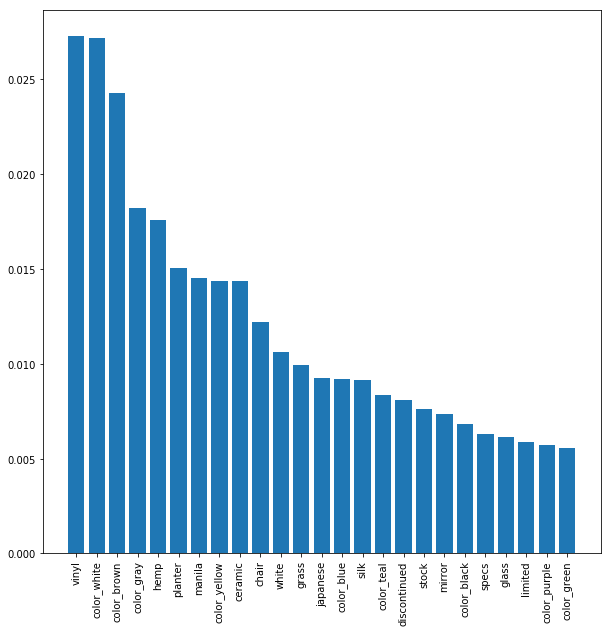


Coastal_style
[[7661  325]
 [ 349 2184]]
tn:  7661 fp:  325 fn:  349 tp:  2184
Precision is:  0.870466321244
Recall is:  0.862218712989
Accuracy is:  0.9359254682
                scores
color_white   0.085219
color_brown   0.048628
chair         0.030995
color_yellow  0.025123
color_gray    0.022351
color_teal    0.017292
ceramic       0.015426
vinyl         0.014118
color_blue    0.013732
specs         0.013570
color_green   0.012839
color_purple  0.009224
color_black   0.009171
mirror        0.009164
hemp          0.008648
planter       0.008600
wooden        0.008494
color_red     0.006838
manila        0.006711
white         0.006301
color_orange  0.005966
metal         0.005902
glass         0.005722
dining        0.005310
silk          0.004806


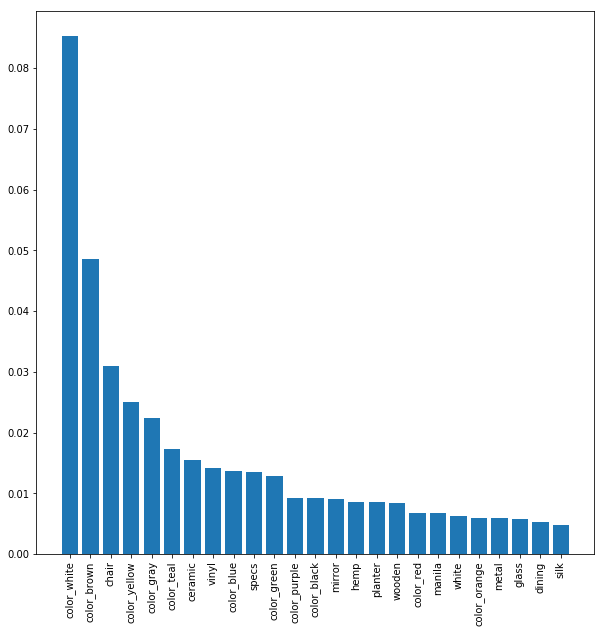


Southwestern_style too small

ArtDeco_style too small

LouisXVI_style too small



In [613]:
test_dict = {}
run_rfcs(df,style_cols,use_cols)

### Results when running rfc
n_estimators = 200
altered vectorizor to smooth_idf=True
max_features, and colors included



Mid-Century_style
[[8366   90]
 [ 693 1370]]
tn:  8366 fp:  90 fn:  693 tp:  1370
Precision is:  0.938356164384
Recall is:  0.664081434804
Accuracy is:  0.92556326647
                scores
color_brown   0.028931
color_white   0.026092
vinyl         0.022862
color_gray    0.019659
specs         0.017359
hemp          0.013083
color_black   0.012513
color_yellow  0.011975
chair         0.011866
planter       0.011791
leather       0.010855
manila        0.010426
color_teal    0.010200
color_blue    0.009435
cor           0.009324
silk          0.009074
grass         0.007746
japanese      0.007189
discontinued  0.006644
color_purple  0.006196
dining        0.006174
stock         0.005749
m2            0.005504
limited       0.005355
mirror        0.005337


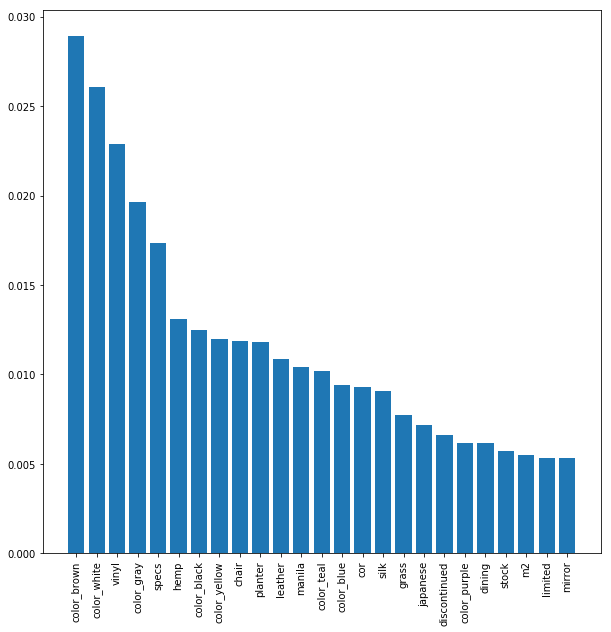


Rustic_style
[[7631  161]
 [ 820 1907]]
tn:  7631 fp:  161 fn:  820 tp:  1907
Precision is:  0.922147001934
Recall is:  0.69930326366
Accuracy is:  0.906740184428
                scores
color_brown   0.029270
color_white   0.027464
chair         0.024486
color_gray    0.023280
color_teal    0.017532
color_yellow  0.015674
color_blue    0.015382
ii            0.013805
color_black   0.010831
specs         0.010823
color_green   0.010521
set           0.009868
color_purple  0.008555
ceramic       0.007132
mirror        0.006797
table         0.006706
wooden        0.006322
metal         0.005561
glass         0.005509
planter       0.005287
dining        0.004853
iii           0.004749
mc            0.004596
30            0.004308
leather       0.004291


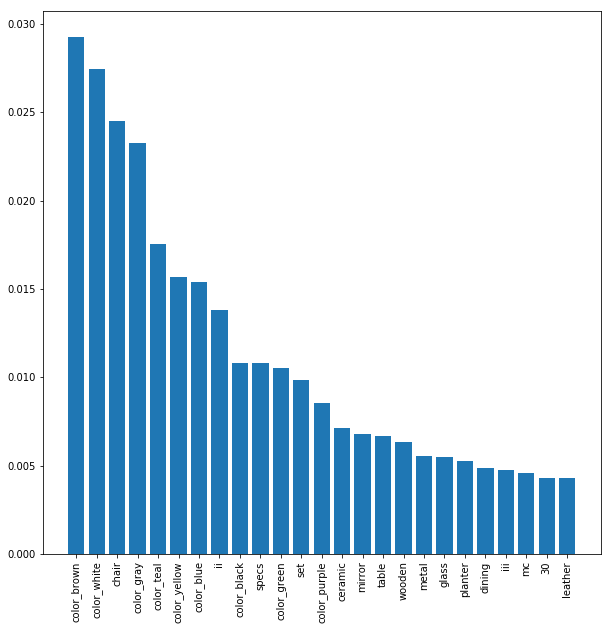


ArtsandCrafts_style
[[9060   34]
 [ 368 1057]]
tn:  9060 fp:  34 fn:  368 tp:  1057
Precision is:  0.968835930339
Recall is:  0.741754385965
Accuracy is:  0.96178343949
                scores
color_white   0.045297
color_brown   0.029774
vinyl         0.027847
color_yellow  0.026078
hemp          0.021264
color_gray    0.020529
color_teal    0.016856
planter       0.016275
chair         0.014891
manila        0.014043
grass         0.012455
color_green   0.011129
color_blue    0.011047
silk          0.009722
limited       0.008511
japanese      0.008097
discontinued  0.008093
stock         0.007936
color_purple  0.007304
color_black   0.007039
linen         0.006371
orchids       0.006007
raffia        0.005918
specs         0.005842
glass         0.005819


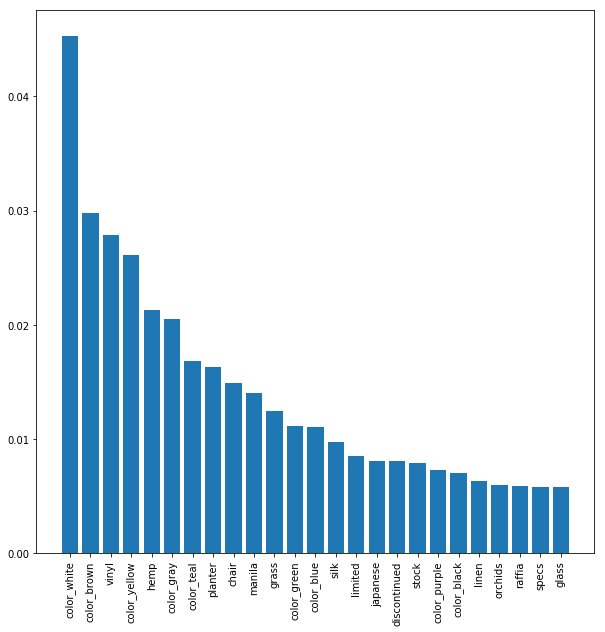


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9811   25]
 [ 360  323]]
tn:  9811 fp:  25 fn:  360 tp:  323
Precision is:  0.92816091954
Recall is:  0.472913616398
Accuracy is:  0.963399562696
                scores
color_yellow  0.035042
color_brown   0.032157
planter       0.030983
color_white   0.025926
color_gray    0.025192
color_teal    0.019652
color_green   0.016026
orchids       0.015057
bracket       0.013963
vase          0.013020
color_blue    0.012995
glass         0.012186
color_black   0.009696
color_purple  0.008686
chair         0.006871
vanda         0.006706
onion         0.006410
ball          0.006388
yellow        0.006369
ceramic       0.005815
grass         0.005747
pearl         0.005655
peonies       0.005468
fern          0.005425
mixed         0.005

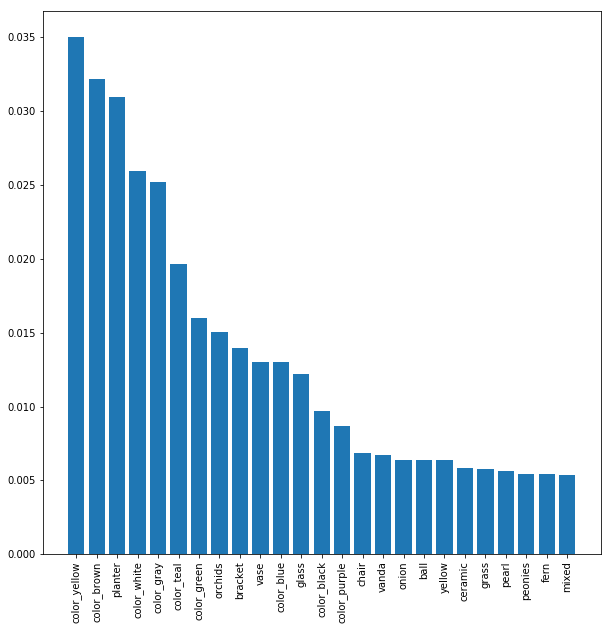


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[3788  959]
 [ 307 5465]]
tn:  3788 fp:  959 fn:  307 tp:  5465
Precision is:  0.850716064757
Recall is:  0.946812196812
Accuracy is:  0.879646354216
                scores
color_white   0.035308
color_brown   0.023958
specs         0.017785
color_gray    0.016731
century       0.014235
chair         0.011727
color_yellow  0.011355
commercial    0.010837
12            0.010278
leather       0.010261
color_black   0.009995
time          0.009385
min           0.009349
color_teal    0.008933
lead          0.008770
color_blue    0.008355
use           0.008063
strength      0.007858
flexibility   0.007508
weight        0.007416
seat          0.00

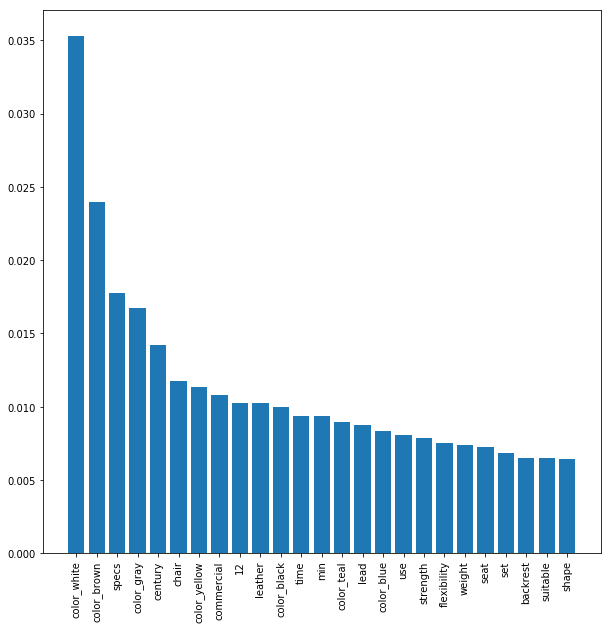


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[5224  630]
 [ 599 4066]]
tn:  5224 fp:  630 fn:  599 tp:  4066
Precision is:  0.865843270869
Recall is:  0.871596998928
Accuracy is:  0.88316379884
                scores
color_white   0.047855
color_brown   0.036288
color_gray    0.024583
color_yellow  0.016811
chair         0.015297
color_teal    0.015238
color_blue    0.013327
specs         0.012556
color_black   0.010911
ii            0.009140
color_purple  0.008486
steel         0.008173
color_green   0.007813
12            0.007602
mirror        0.007427
injecting     0.006497
time          0.006314
set           0.006268
dining        0.006173
century       0.005761
30            0.005710
molded        0.005512
use           0.005506
lounge        0.005201
comfortable   0.005031


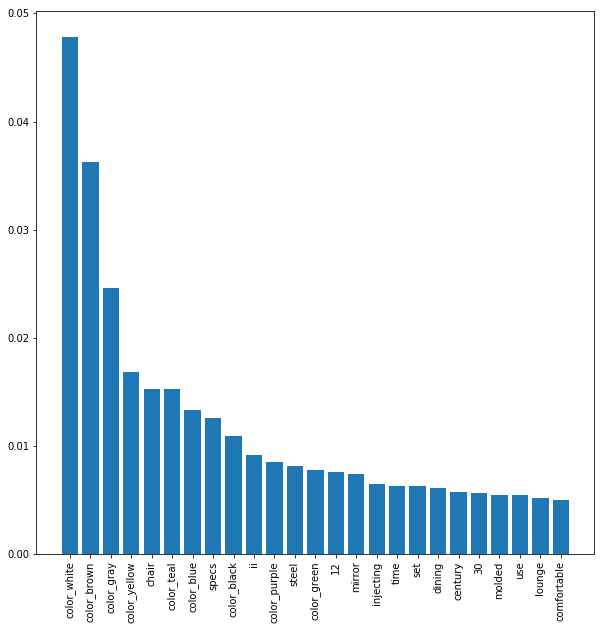


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[9819   20]
 [ 363  317]]
tn:  9819 fp:  20 fn:  363 tp:  317
Precision is:  0.940652818991
Recall is:  0.466176470588
Accuracy is:  0.963589694838
                scores
color_yellow  0.036436
planter       0.033539
color_brown   0.032049
color_gray    0.025712
color_white   0.025634
color_teal    0.018011
color_green   0.017254
glass         0.013735
bracket       0.013181
orchids       0.013021
color_blue    0.012740
vase          0.010657
color_black   0.008206
color_purple  0.008199
chair         0.007028
vanda         0.006425
ceramic       0.006246
fern          0.006127
peonies       0.005981
hydrangeas    0.005876
finial        0.005793
ball          0.005678
onion         0.005193
mirror        0.005164
yellow        0.005091


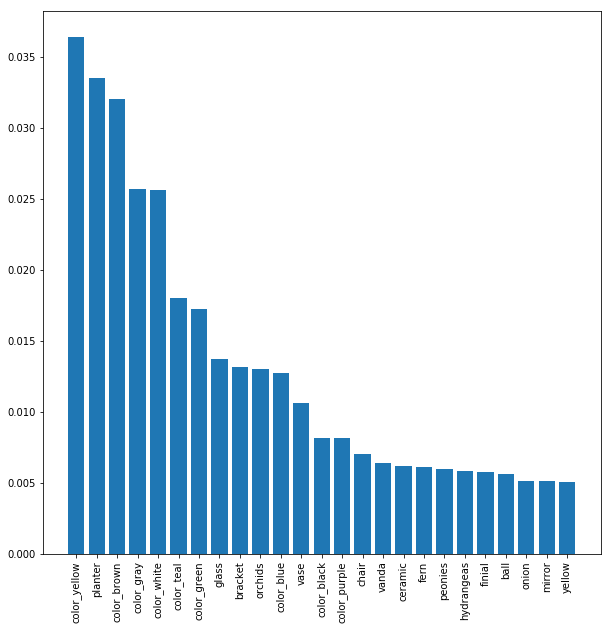


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[7487  194]
 [ 489 2349]]
tn:  7487 fp:  194 fn:  489 tp:  2349
Precision is:  0.923712151003
Recall is:  0.827695560254
Accuracy is:  0.935069873562
                scores
chair         0.040906
color_white   0.032055
color_brown   0.030492
color_teal    0.023898
color_gray    0.020883
color_yellow  0.019114
color_blue    0.016560
color_black   0.015809
specs         0.014075
ii            0.013382
color_green   0.012547
vinyl         0.012432
color_purple  0.009885
mirror        0.007471
hemp          0.007299
set           0.006371
wooden        0.006360
manila        0.006212
seat          0.006023
sofa          0.005930
lounge        0.005923
metal         0.005792
dining        0.005788
white         0.005368
ceramic       0.00519

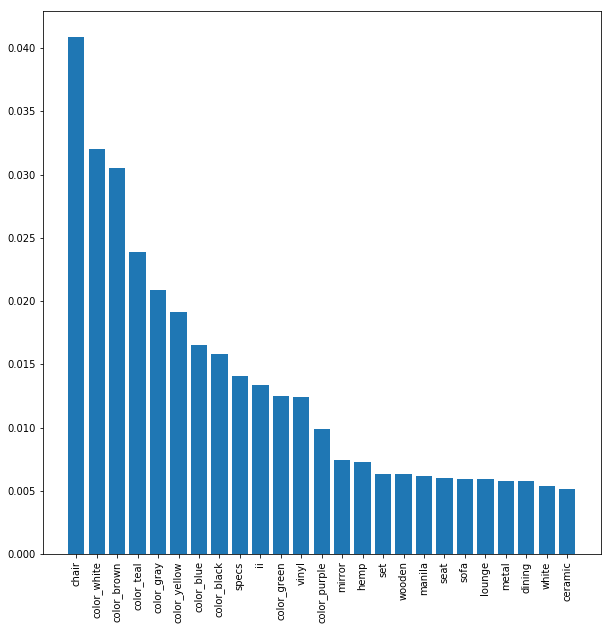


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[6655  288]
 [ 580 2996]]
tn:  6655 fp:  288 fn:  580 tp:  2996
Precision is:  0.912302070646
Recall is:  0.837807606264
Accuracy is:  0.917482650442
                scores
color_white   0.029142
color_brown   0.026904
time          0.019770
color_gray    0.019656
color_yellow  0.019302
lead          0.018314
color_teal    0.013197
weight        0.013159
chair         0.013108
structure     0.012412
12            0.011882
residential   0.011747
max           0.011177
molded        0.010925
leather       0.010907
color_black   0.010855
color_blue    0.010469
color_green   0.010317
injecting     0.010257
shape         0.010253
extra         0.009731
springs       0.009567
color_red     0.009455
use           0.009231
strength      0.008942


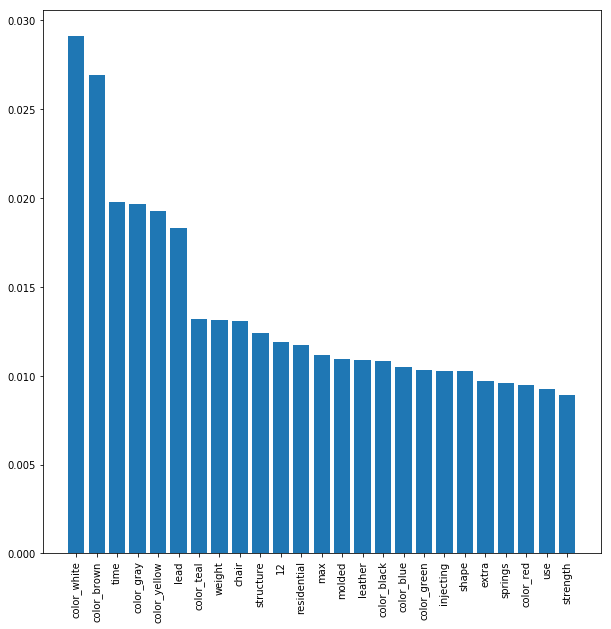


Contemporary_style
[[1905  954]
 [ 255 7405]]
tn:  1905 fp:  954 fn:  255 tp:  7405
Precision is:  0.885871515732
Recall is:  0.966710182768
Accuracy is:  0.885065120259
                scores
color_white   0.030629
color_brown   0.028060
chair         0.023073
color_gray    0.020207
century       0.019271
specs         0.016911
color_yellow  0.014075
leather       0.012685
color_black   0.011266
color_teal    0.010414
color_blue    0.010157
bradington    0.009384
young         0.009028
inches        0.008366
color_purple  0.007525
color_green   0.006799
set           0.006292
mirror        0.005911
dining        0.005210
painting      0.005087
lounge        0.004886
loveseat      0.004852
metal         0.004824
chairs        0.004571
color_orange  0.004123


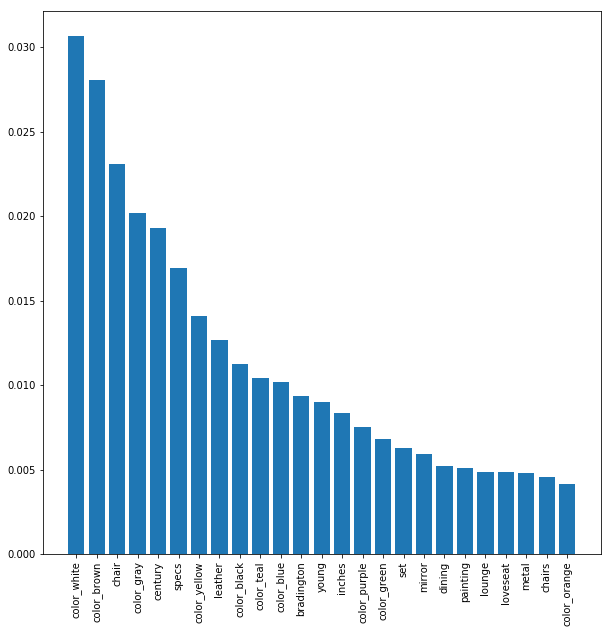


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[8775   42]
 [ 413 1289]]
tn:  8775 fp:  42 fn:  413 tp:  1289
Precision is:  0.968444778362
Recall is:  0.757344300823
Accuracy is:  0.956744937732
                scores
vinyl         0.027966
color_white   0.027317
color_brown   0.024812
color_gray    0.018040
hemp          0.015762
ceramic       0.015066
color_yellow  0.014054
manila        0.013509
chair         0.012993
grass         0.011590
white         0.011457
planter       0.010568
color_blue    0.008581
silk          0.008549
color_teal    0.008342
japanese      0.008021
discontinued  0.007479
mirror        0.007306
limited       0.007261
stock         0.007180
specs         0.007144
color_black   0.007140
glass         0.006506
linen         0.006000
color_green   0.005517


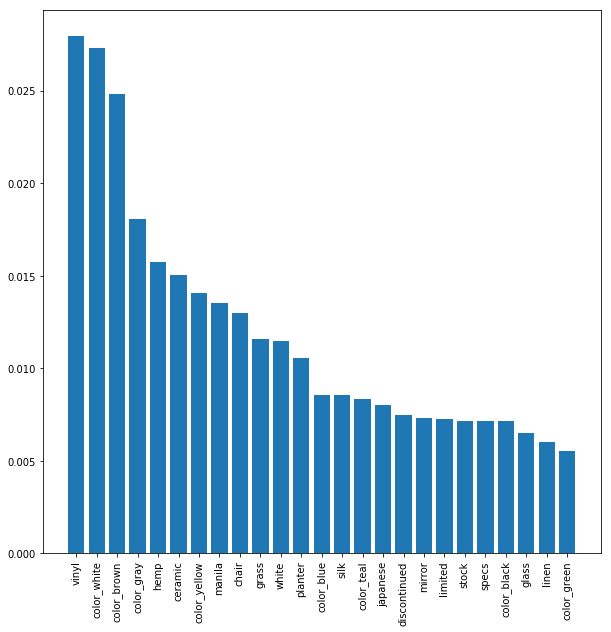


Coastal_style
[[7798  322]
 [ 282 2117]]
tn:  7798 fp:  322 fn:  282 tp:  2117
Precision is:  0.867978679787
Recall is:  0.882451021259
Accuracy is:  0.942580093165
                scores
color_white   0.088349
color_brown   0.045616
chair         0.029308
color_yellow  0.024537
color_gray    0.021982
color_teal    0.017539
vinyl         0.014205
color_blue    0.013963
ceramic       0.013751
color_green   0.012542
specs         0.011558
color_purple  0.009556
hemp          0.009473
planter       0.009284
color_black   0.009179
mirror        0.009146
wooden        0.008106
color_red     0.007723
manila        0.007306
white         0.006766
color_orange  0.006250
glass         0.005558
dining        0.005427
metal         0.005329
grass         0.005197


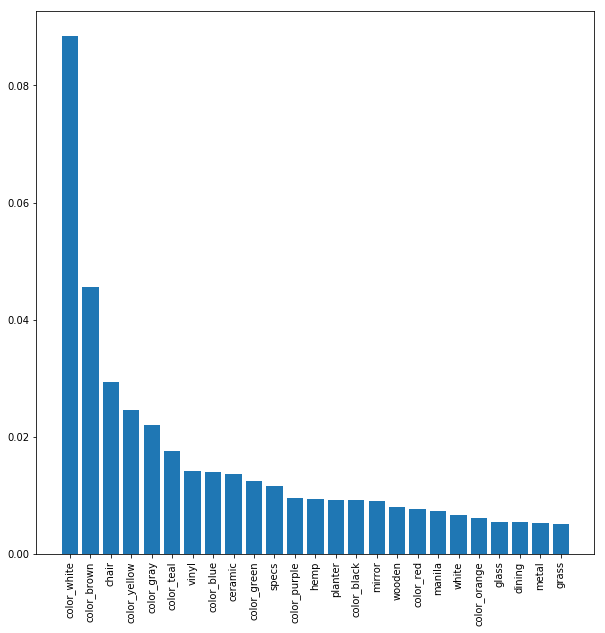


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [854]:
run_rfcs(df,style_cols,use_cols)

### Results with rfc, including showroom_ids as dummies, and smooth_idf=False

Mid-Century_style
[[8356  113]
 [ 565 1485]]
tn:  8356 fp:  113 fn:  565 tp:  1485
Precision is:  0.92928660826
Recall is:  0.724390243902
Accuracy is:  0.935545203917
                scores
color_white   0.025530
id_72         0.024944
id_70         0.024696
id_69         0.024267
color_brown   0.022434
specs         0.019586
id_71         0.019138
id_33         0.017789
id_3          0.017387
id_73         0.016458
color_gray    0.016086
id_2          0.015192
id_9          0.014896
id_53         0.013958
chair         0.013263
id_4          0.013258
id_22         0.012420
color_black   0.011914
id_10         0.010517
color_yellow  0.010039
leather       0.009809
planter       0.009014
cor           0.008967
id_32         0.008804
id_43         0.008630


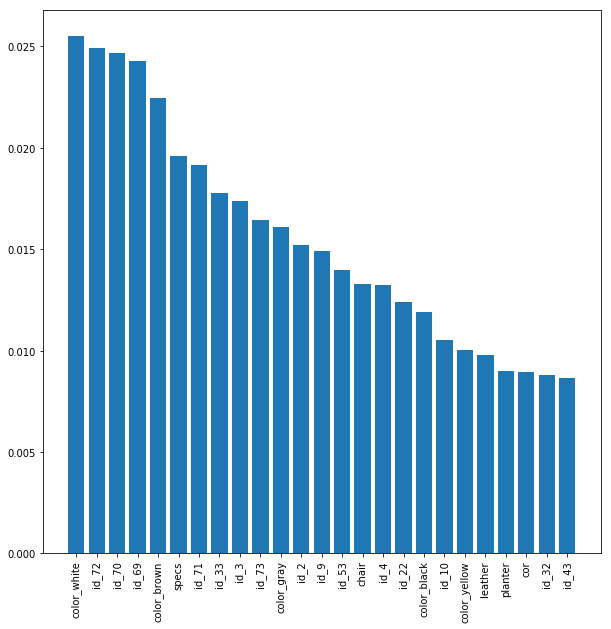


Rustic_style
[[7718  200]
 [ 548 2053]]
tn:  7718 fp:  200 fn:  548 tp:  2053
Precision is:  0.911229471815
Recall is:  0.789311803153
Accuracy is:  0.928890578952
                scores
color_white   0.029614
color_brown   0.027642
chair         0.025329
color_gray    0.022698
color_teal    0.019740
color_yellow  0.017160
color_blue    0.016237
ii            0.013302
color_black   0.012642
color_green   0.012611
specs         0.011875
id_92         0.010637
id_129        0.010060
color_purple  0.009377
id_137        0.008333
id_136        0.008262
id_107        0.007753
id_182        0.007336
id_33         0.006514
set           0.006228
id_32         0.006196
ceramic       0.006005
dining        0.005348
mirror        0.005304
wooden        0.005187


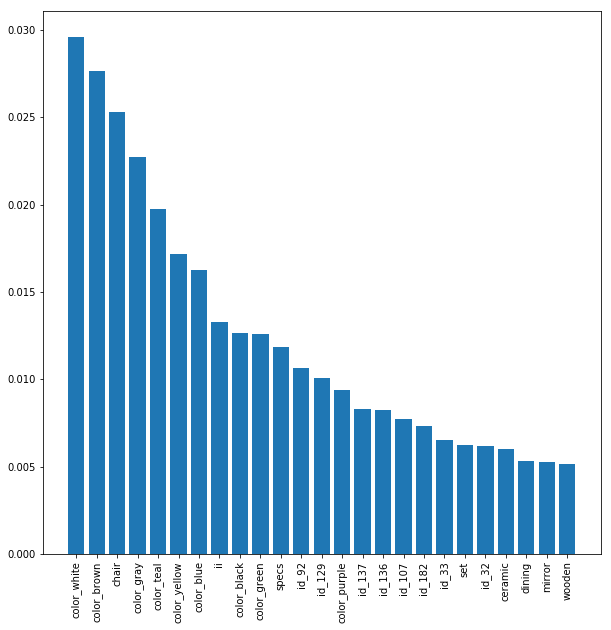


ArtsandCrafts_style
[[9011   44]
 [ 168 1296]]
tn:  9011 fp:  44 fn:  168 tp:  1296
Precision is:  0.967164179104
Recall is:  0.885245901639
Accuracy is:  0.979845992965
                scores
id_53         0.040326
id_33         0.036196
id_3          0.033882
id_70         0.032215
id_69         0.030159
id_2          0.028671
id_92         0.026864
id_32         0.025336
id_107        0.025039
id_10         0.024943
color_white   0.024942
id_6          0.022104
id_72         0.021895
id_43         0.021145
id_71         0.018872
id_9          0.016853
color_yellow  0.015704
id_4          0.015207
color_brown   0.013976
id_22         0.013445
color_gray    0.011080
planter       0.010791
id_73         0.009803
id_76         0.009729
color_teal    0.008117


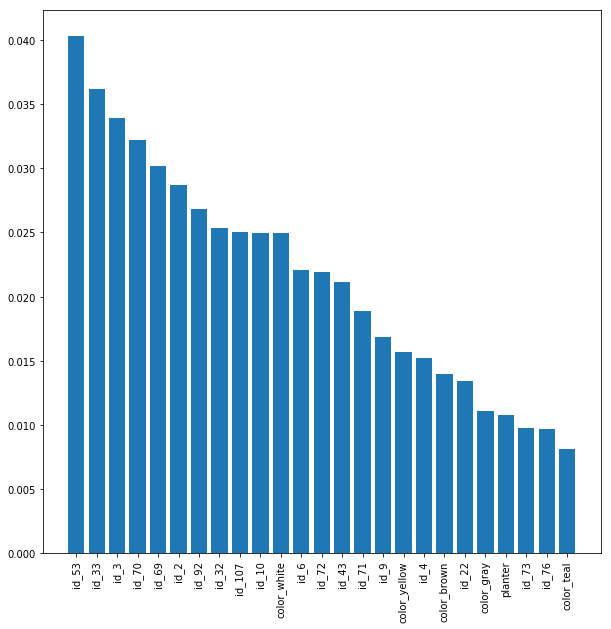


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9828   36]
 [ 140  515]]
tn:  9828 fp:  36 fn:  140 tp:  515
Precision is:  0.934664246824
Recall is:  0.786259541985
Accuracy is:  0.983268371518
                scores
id_92         0.065870
id_107        0.048480
id_33         0.040409
color_yellow  0.033406
color_white   0.031231
color_brown   0.025654
id_76         0.024605
planter       0.020306
color_gray    0.018437
color_teal    0.015434
color_green   0.011243
chair         0.010486
bracket       0.010467
glass         0.009658
id_129        0.009459
color_blue    0.009287
orchids       0.009073
id_137        0.008754
color_black   0.008281
vase          0.007352
id_136        0.006818
mirror        0.006479
color_purple  0.006073
ball          0.005914
color_orange  0.00

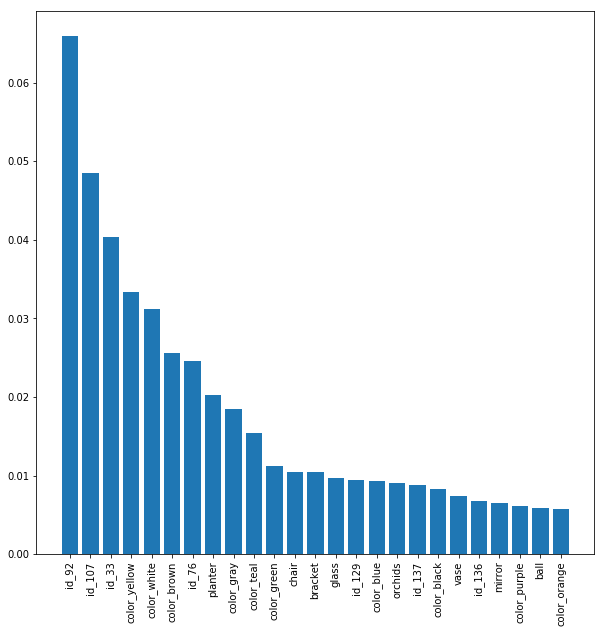


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[3925  806]
 [ 329 5459]]
tn:  3925 fp:  806 fn:  329 tp:  5459
Precision is:  0.871348762969
Recall is:  0.943158258466
Accuracy is:  0.892100009507
                scores
color_white   0.028014
color_brown   0.021156
specs         0.017609
color_gray    0.015381
comfortable   0.012781
time          0.011405
color_yellow  0.010475
chair         0.009969
color_black   0.009451
flexibility   0.009191
leather       0.009082
id_129        0.008987
id_137        0.008962
seat          0.008550
color_teal    0.008180
upholstered   0.008146
backrest      0.007986
id_136        0.007940
structure     0.007809
12            0.007760
color_blue    0.00

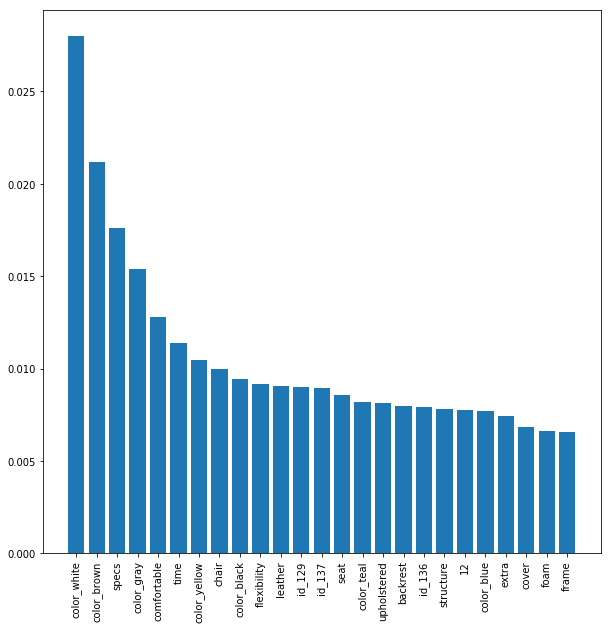


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[5332  457]
 [ 529 4201]]
tn:  5332 fp:  457 fn:  529 tp:  4201
Precision is:  0.901889222842
Recall is:  0.888160676533
Accuracy is:  0.906264854074
                scores
color_white   0.033397
color_brown   0.031398
color_gray    0.020803
chair         0.015599
color_yellow  0.014710
color_teal    0.013491
color_blue    0.012678
color_black   0.009836
specs         0.008800
id_33         0.008131
id_4          0.008083
color_purple  0.007721
color_green   0.007448
ii            0.006988
id_32         0.006678
id_71         0.006341
dining        0.006334
id_10         0.006084
mirror        0.006008
id_6          0.005982
id_22         0.005902
time          0.005803
id_136        0.005784
lead          0.005729
id_69         0.005427


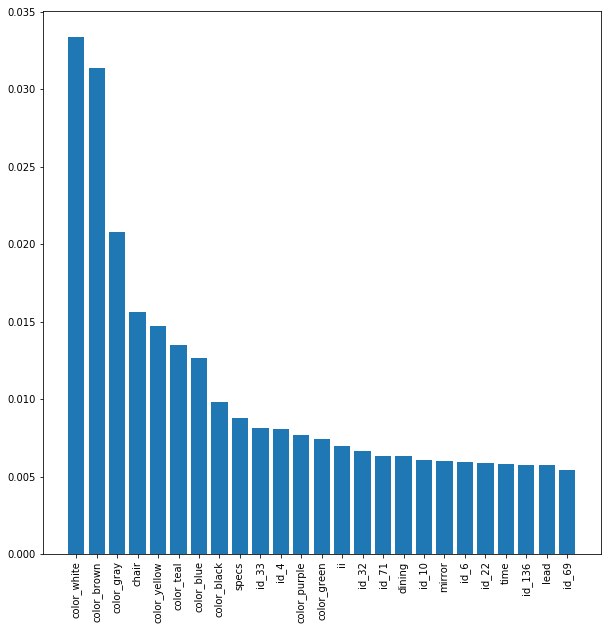


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[9828   30]
 [ 147  514]]
tn:  9828 fp:  30 fn:  147 tp:  514
Precision is:  0.944852941176
Recall is:  0.7776096823
Accuracy is:  0.983173305447
                scores
id_107        0.057333
id_92         0.053028
id_33         0.035286
color_yellow  0.032051
color_white   0.029916
planter       0.025009
color_brown   0.024619
id_76         0.021445
color_gray    0.019565
color_teal    0.014349
bracket       0.012393
color_green   0.011989
orchids       0.011388
glass         0.009905
chair         0.009178
color_blue    0.009008
vase          0.008493
color_black   0.008082
id_129        0.007670
id_137        0.007634
mirror        0.006856
id_136        0.006710
color_purple  0.006070
grass         0.005989
ball          0.005784


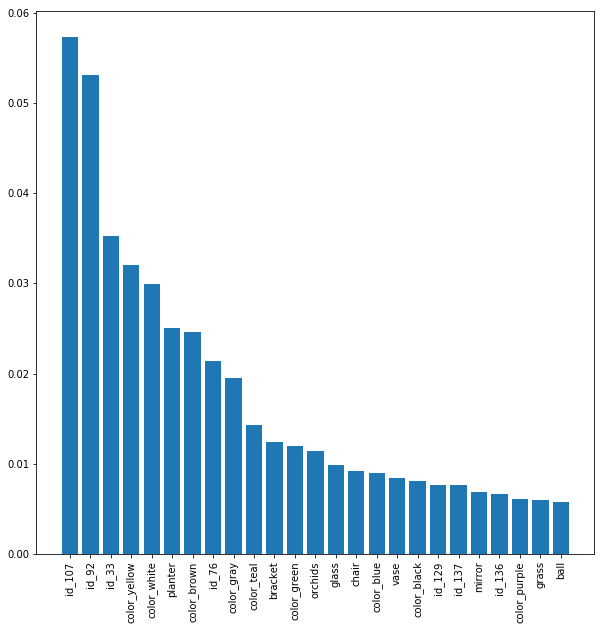


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[7514  138]
 [ 286 2581]]
tn:  7514 fp:  138 fn:  286 tp:  2581
Precision is:  0.949246046341
Recall is:  0.900244157656
Accuracy is:  0.95969198593
                scores
id_33         0.027355
color_white   0.027352
chair         0.024735
color_brown   0.020408
color_teal    0.020230
id_92         0.018445
ii            0.016532
color_gray    0.015651
color_blue    0.014347
color_yellow  0.013715
id_70         0.012876
id_53         0.012124
id_3          0.011450
id_72         0.011274
color_green   0.010861
id_10         0.010537
id_71         0.010136
id_2          0.010002
id_137        0.009900
id_69         0.009777
id_6          0.009635
id_76         0.009619
color_black   0.009488
specs         0.008161
id_136        0.008144

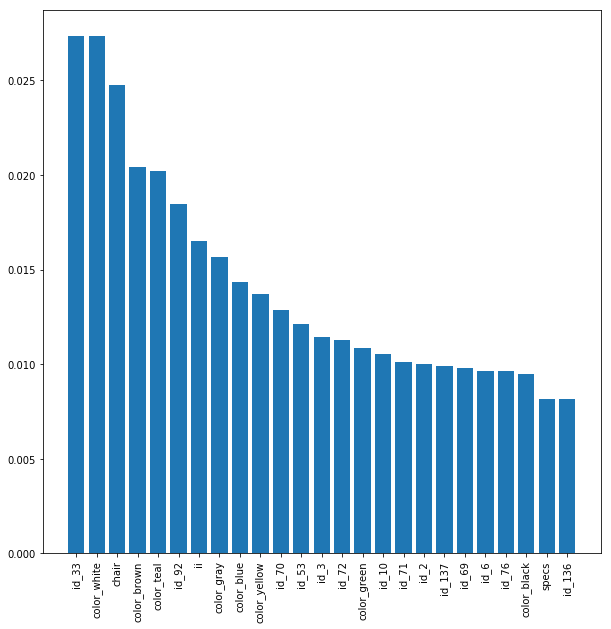


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[6709  209]
 [ 350 3251]]
tn:  6709 fp:  209 fn:  350 tp:  3251
Precision is:  0.939595375723
Recall is:  0.902804776451
Accuracy is:  0.946858066356
                scores
color_white   0.028463
color_brown   0.024856
id_92         0.019023
color_yellow  0.016818
time          0.016454
color_gray    0.016427
springs       0.015024
use           0.014683
commercial    0.013524
12            0.012445
strength      0.011899
color_teal    0.011854
extra         0.011117
designed      0.011055
polyurethane  0.010688
chair         0.010445
id_107        0.010090
weight        0.009683
backrest      0.009464
color_blue    0.009357
min           0.009226
color_black   0.009216
id_33         0.009088
residential   0.009010
lead          0.008961


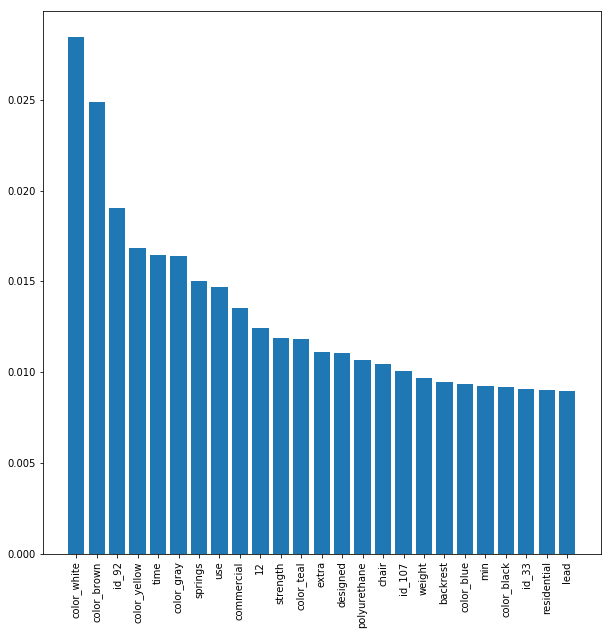


Contemporary_style
[[2108  772]
 [ 287 7352]]
tn:  2108 fp:  772 fn:  287 tp:  7352
Precision is:  0.904972919744
Recall is:  0.962429637387
Accuracy is:  0.899325030896
                scores
color_white   0.026532
color_brown   0.026503
color_gray    0.019227
chair         0.015976
specs         0.015358
leather       0.013109
color_yellow  0.013028
id_182        0.011629
color_teal    0.010274
color_black   0.009967
bradington    0.009422
color_blue    0.009210
young         0.008843
id_33         0.008061
color_purple  0.007140
id_95         0.006364
color_green   0.006359
set           0.006292
inches        0.006279
id_97         0.006015
mirror        0.005362
century       0.005093
id_6          0.004910
dining        0.004811
id_98         0.004745


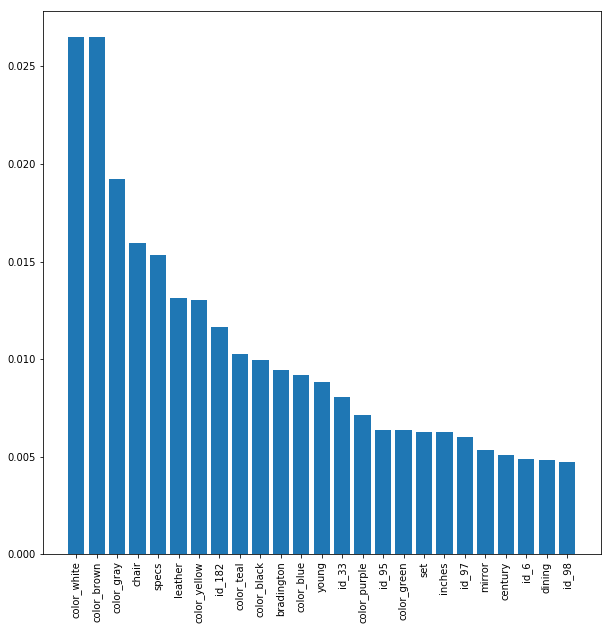


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[8788   69]
 [ 246 1416]]
tn:  8788 fp:  69 fn:  246 tp:  1416
Precision is:  0.953535353535
Recall is:  0.851985559567
Accuracy is:  0.97005418766
                scores
id_70         0.037708
id_73         0.032429
id_72         0.030696
id_69         0.028535
color_white   0.022329
id_43         0.022147
id_2          0.021253
id_71         0.020341
id_33         0.019863
id_6          0.018211
id_22         0.017832
id_10         0.017442
color_brown   0.016740
id_3          0.016085
id_53         0.016063
id_9          0.015877
ceramic       0.015497
color_gray    0.011611
planter       0.010347
color_yellow  0.010306
id_4          0.010168
id_32         0.008645
chair         0.008375
id_92         0.006755
mirror        0.006683


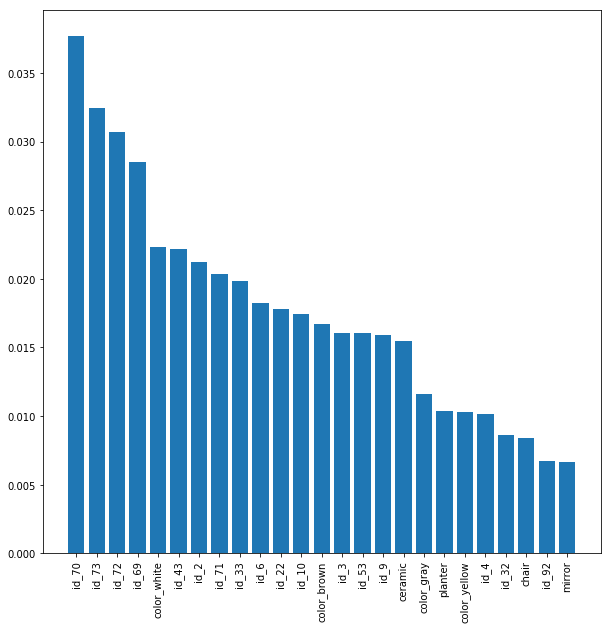


Coastal_style
[[7920  230]
 [ 200 2169]]
tn:  7920 fp:  230 fn:  200 tp:  2169
Precision is:  0.904126719466
Recall is:  0.915576192486
Accuracy is:  0.959121589505
                scores
color_white   0.052023
color_brown   0.036315
id_33         0.028719
id_72         0.020964
color_yellow  0.020913
chair         0.019970
id_3          0.018620
color_gray    0.017203
id_2          0.015567
ceramic       0.014466
id_53         0.014228
color_teal    0.014209
id_9          0.012606
id_70         0.012473
id_43         0.012332
id_92         0.011946
color_green   0.011090
id_71         0.011068
id_10         0.010612
color_blue    0.010507
id_107        0.010476
id_4          0.010375
id_6          0.009623
color_red     0.008725
wooden        0.008342


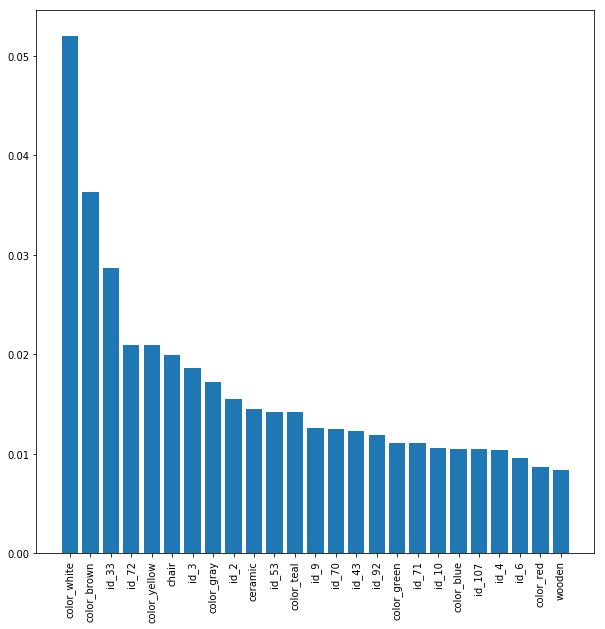


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [872]:
run_rfcs(df,style_cols,use_cols)

Mid-Century_style
[[8343  101]
 [ 592 1483]]
tn:  8343 fp:  101 fn:  592 tp:  1483
Precision is:  0.936237373737
Recall is:  0.714698795181
Accuracy is:  0.934119212853
                scores
color_white   0.025321
color_brown   0.022747
id_70         0.019900
id_69         0.019459
id_3          0.018732
id_33         0.018319
id_71         0.018038
id_53         0.017858
specs         0.017732
id_2          0.016659
id_43         0.016430
id_72         0.016087
color_gray    0.015804
id_73         0.015130
id_10         0.014604
id_9          0.013413
id_6          0.013317
color_black   0.012491
chair         0.012359
id_32         0.011308
id_22         0.010998
color_yellow  0.010377
leather       0.009894
id_4          0.009618
planter       0.008864


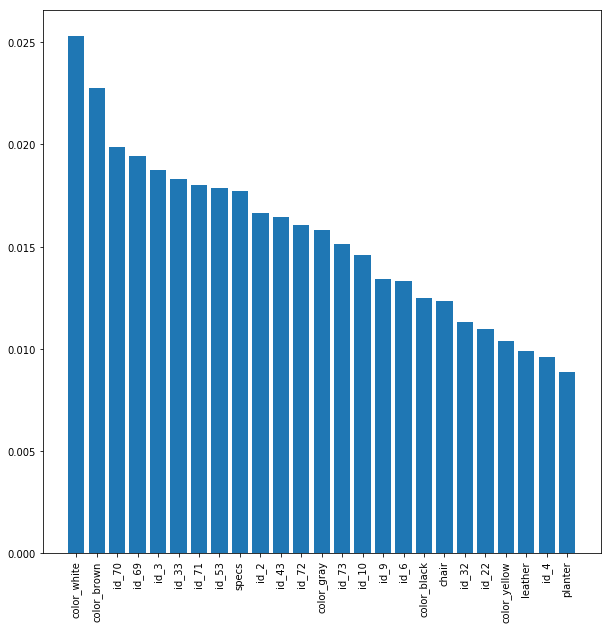


Rustic_style
[[7703  187]
 [ 538 2091]]
tn:  7703 fp:  187 fn:  538 tp:  2091
Precision is:  0.917910447761
Recall is:  0.795359452263
Accuracy is:  0.931077098584
                scores
color_white   0.030173
color_brown   0.026641
chair         0.024496
color_gray    0.023508
color_teal    0.019842
color_yellow  0.016525
color_blue    0.016353
color_black   0.012269
specs         0.012189
color_green   0.012090
ii            0.011938
id_92         0.011326
id_129        0.010183
color_purple  0.009481
id_136        0.008681
id_137        0.008509
id_182        0.007371
id_107        0.006705
set           0.006572
id_33         0.006364
ceramic       0.006218
wooden        0.005758
id_76         0.005584
id_32         0.005541
mirror        0.005320


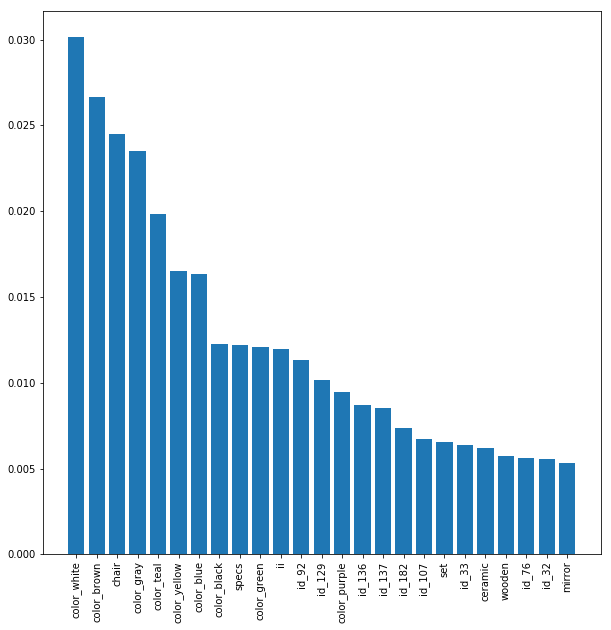


ArtsandCrafts_style
[[9029   28]
 [ 175 1287]]
tn:  9029 fp:  28 fn:  175 tp:  1287
Precision is:  0.978707224335
Recall is:  0.880300957592
Accuracy is:  0.980701587603
                scores
id_33         0.048295
id_69         0.030302
id_53         0.029577
id_70         0.029551
id_92         0.026921
id_3          0.026267
id_73         0.025126
id_43         0.024793
color_white   0.023735
id_71         0.023674
id_72         0.023488
id_10         0.023481
id_107        0.023080
id_9          0.022390
id_2          0.021797
id_22         0.020087
id_6          0.019405
id_32         0.014471
color_yellow  0.014374
color_brown   0.014049
id_4          0.012240
planter       0.010731
id_76         0.010410
color_gray    0.010284
color_teal    0.008307


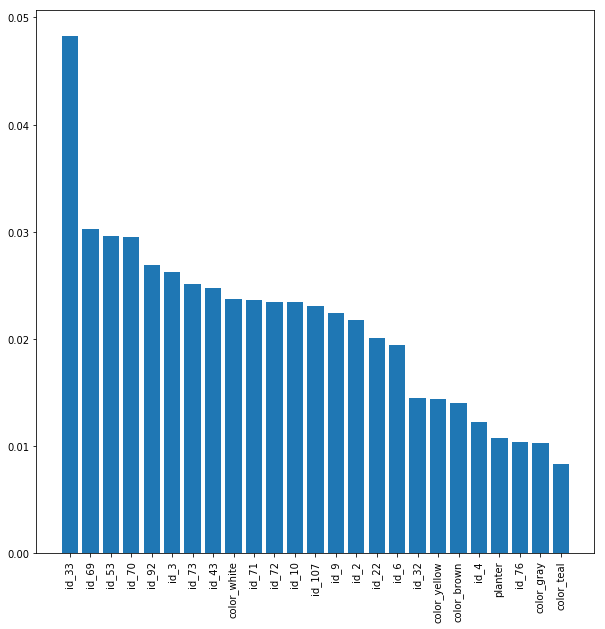


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9807   24]
 [ 163  525]]
tn:  9807 fp:  24 fn:  163 tp:  525
Precision is:  0.956284153005
Recall is:  0.763081395349
Accuracy is:  0.982222644738
                scores
id_92         0.058481
id_107        0.057001
id_33         0.038108
color_yellow  0.032875
color_white   0.030178
planter       0.025600
color_brown   0.024977
id_76         0.022736
color_gray    0.019088
color_teal    0.014905
color_green   0.011555
bracket       0.010565
orchids       0.010448
glass         0.010441
chair         0.009433
color_blue    0.009288
vase          0.008204
color_black   0.007841
id_136        0.007796
mirror        0.007371
id_129        0.007163
id_137        0.006771
color_purple  0.006418
color_orange  0.005681
pearl         0.00

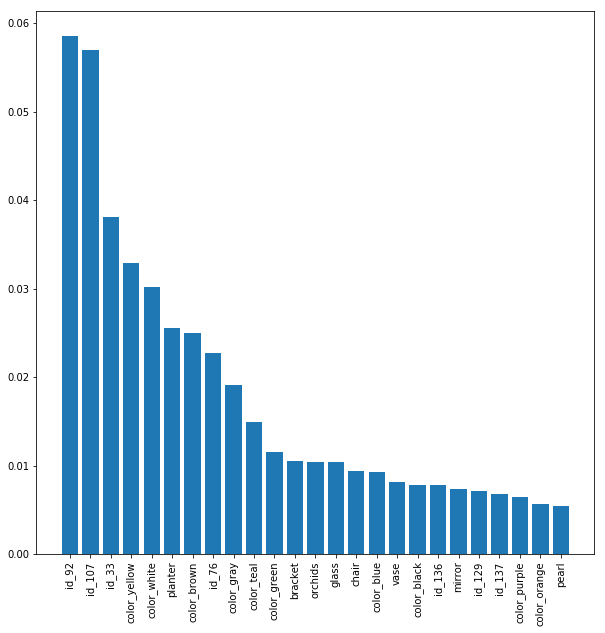


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[3936  775]
 [ 323 5485]]
tn:  3936 fp:  775 fn:  323 tp:  5485
Precision is:  0.876198083067
Recall is:  0.944387052342
Accuracy is:  0.895617454131
                scores
color_white   0.028842
color_brown   0.020680
specs         0.017652
color_gray    0.015778
color_yellow  0.010907
chair         0.010626
foam          0.009696
color_black   0.009580
id_137        0.009427
leather       0.008776
id_136        0.008576
id_129        0.008327
color_teal    0.008032
color_blue    0.007949
injecting     0.007633
seat          0.007462
12            0.007424
min           0.007237
time          0.007199
lead          0.007062
use           0.00

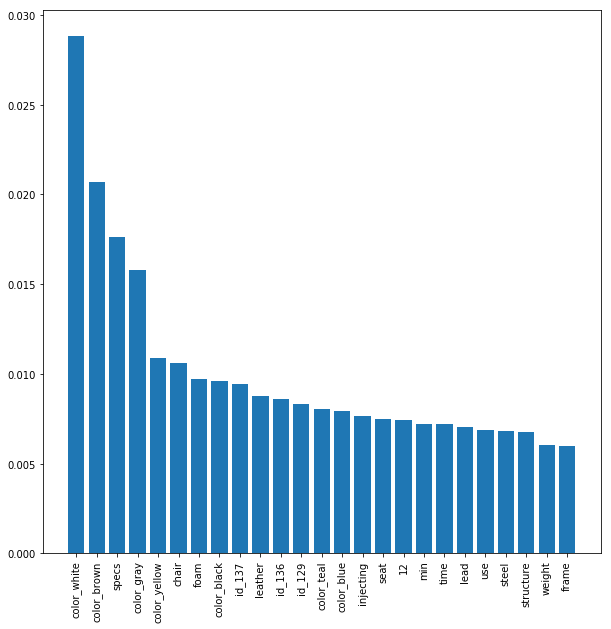


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[5376  474]
 [ 512 4157]]
tn:  5376 fp:  474 fn:  512 tp:  4157
Precision is:  0.897646296696
Recall is:  0.890340544014
Accuracy is:  0.906264854074
                scores
color_white   0.033914
color_brown   0.031286
color_gray    0.020890
chair         0.015837
color_yellow  0.015142
color_teal    0.013364
color_blue    0.012854
color_black   0.009860
specs         0.008988
id_33         0.007809
color_purple  0.007670
color_green   0.007456
id_4          0.006970
ii            0.006789
dining        0.006246
id_32         0.006218
id_10         0.005923
mirror        0.005915
id_6          0.005913
id_22         0.005840
sofa          0.005405
id_73         0.005385
id_137        0.005254
time          0.005106
id_136        0.004959


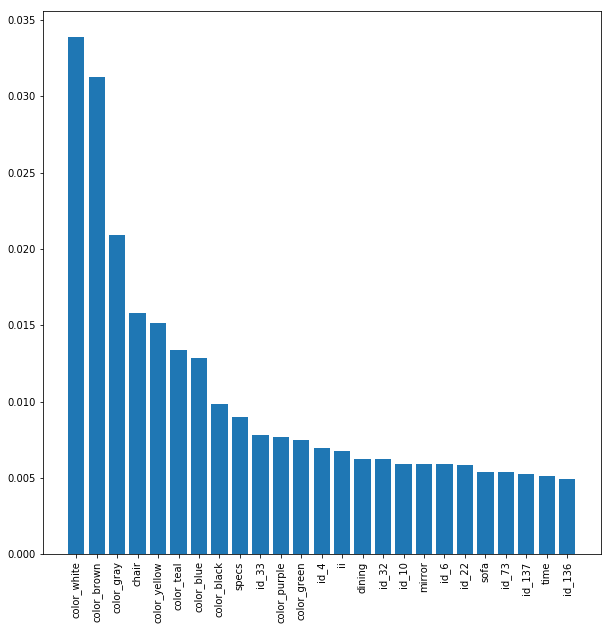


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[9862   29]
 [ 140  488]]
tn:  9862 fp:  29 fn:  140 tp:  488
Precision is:  0.943907156673
Recall is:  0.777070063694
Accuracy is:  0.983933834015
                scores
id_92         0.062187
id_107        0.050737
id_33         0.040735
color_yellow  0.031059
color_white   0.030075
color_brown   0.024814
planter       0.024059
id_76         0.021490
color_gray    0.019660
color_teal    0.014712
color_green   0.011931
bracket       0.010370
chair         0.010178
vase          0.010068
glass         0.009729
orchids       0.009307
color_blue    0.009204
id_129        0.008708
id_137        0.007947
color_black   0.007476
id_136        0.007165
mirror        0.006810
finial        0.006324
color_purple  0.006161
ceramic       0.005966


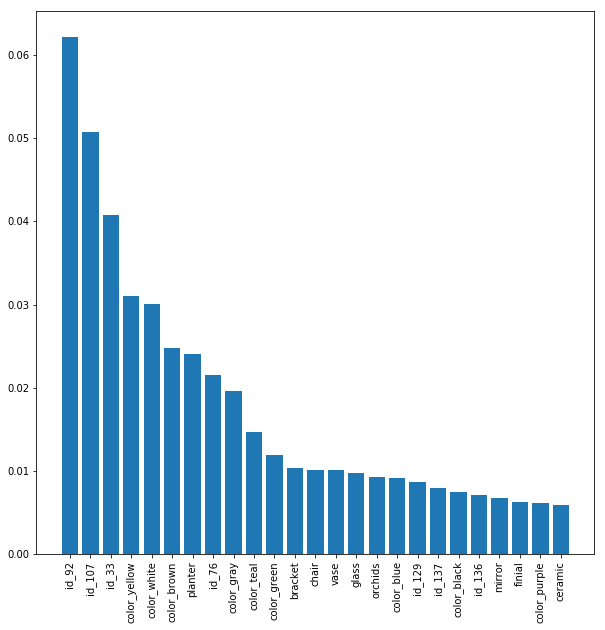


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[7493  111]
 [ 306 2609]]
tn:  7493 fp:  111 fn:  306 tp:  2609
Precision is:  0.959191176471
Recall is:  0.895025728988
Accuracy is:  0.960357448427
                scores
color_white   0.027129
id_33         0.025670
chair         0.023710
id_92         0.021327
color_teal    0.020972
color_brown   0.020628
color_gray    0.016534
ii            0.015818
id_53         0.014158
color_blue    0.013390
id_70         0.013376
color_yellow  0.013205
id_69         0.011815
id_2          0.011270
color_green   0.010594
color_black   0.010475
id_3          0.009903
id_72         0.009830
id_43         0.009718
id_71         0.008914
id_10         0.008663
id_137        0.008594
id_9          0.008399
specs         0.008248
id_136        0.00817

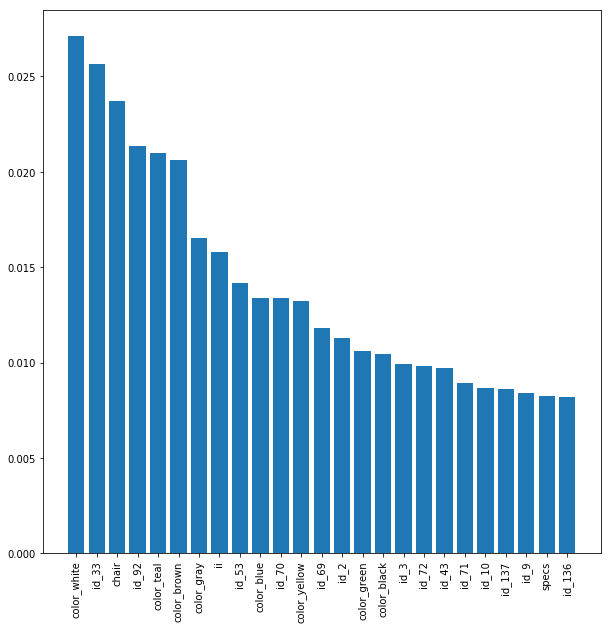


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[6682  222]
 [ 343 3272]]
tn:  6682 fp:  222 fn:  343 tp:  3272
Precision is:  0.936462507155
Recall is:  0.905117565698
Accuracy is:  0.946287669931
                scores
color_white   0.028062
color_brown   0.025075
id_92         0.019659
color_yellow  0.016776
color_gray    0.016561
steel         0.012687
color_teal    0.011994
12            0.011482
weight        0.011158
time          0.010780
id_33         0.010758
chair         0.010716
min           0.010656
lead          0.010387
commercial    0.010172
designed      0.010010
id_107        0.009665
color_black   0.009663
frame         0.009633
foam          0.009550
structure     0.009548
color_green   0.009165
color_blue    0.009133
residential   0.008916
polyurethane  0.008767


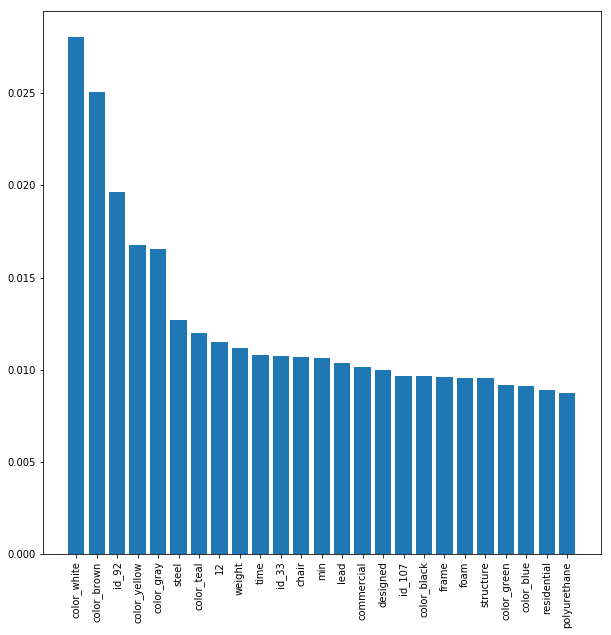


Contemporary_style
[[1984  760]
 [ 254 7521]]
tn:  1984 fp:  760 fn:  254 tp:  7521
Precision is:  0.908223644487
Recall is:  0.967331189711
Accuracy is:  0.903603004088
                scores
color_white   0.026749
color_brown   0.026290
color_gray    0.018950
chair         0.016369
specs         0.015370
color_yellow  0.013276
leather       0.012745
id_182        0.011961
color_black   0.010194
color_teal    0.010047
color_blue    0.009241
young         0.009019
bradington    0.008877
id_33         0.008021
color_purple  0.007007
set           0.006451
inches        0.006391
color_green   0.006361
century       0.005462
id_97         0.005454
mirror        0.005225
id_93         0.005131
id_94         0.004906
id_95         0.004847
id_92         0.004844


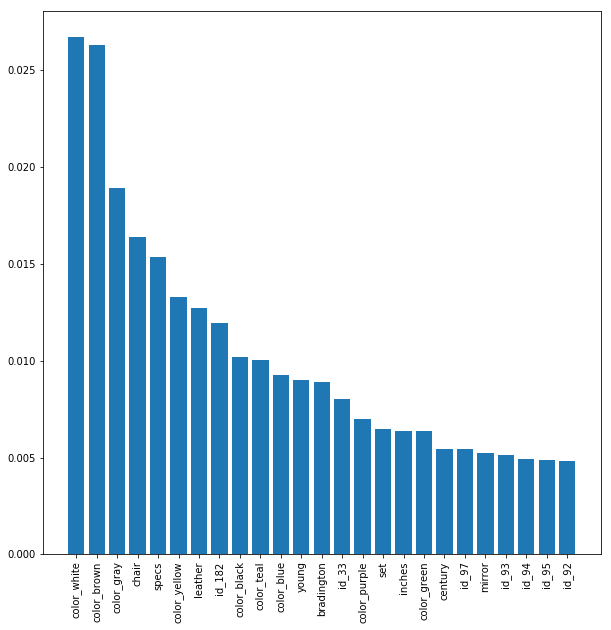


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[8768   47]
 [ 287 1417]]
tn:  8768 fp:  47 fn:  287 tp:  1417
Precision is:  0.967896174863
Recall is:  0.831572769953
Accuracy is:  0.968247932313
                scores
id_72         0.027946
id_33         0.024742
id_70         0.024455
id_69         0.023695
id_71         0.023235
id_53         0.022752
id_43         0.022659
id_3          0.021873
color_white   0.021647
id_2          0.021534
id_73         0.020766
id_9          0.020672
id_6          0.019397
id_10         0.017877
color_brown   0.016060
ceramic       0.014848
id_4          0.013723
id_22         0.012308
id_32         0.012124
color_gray    0.011911
color_yellow  0.010369
planter       0.010239
chair         0.008307
mirror        0.006775
id_92         0.006473


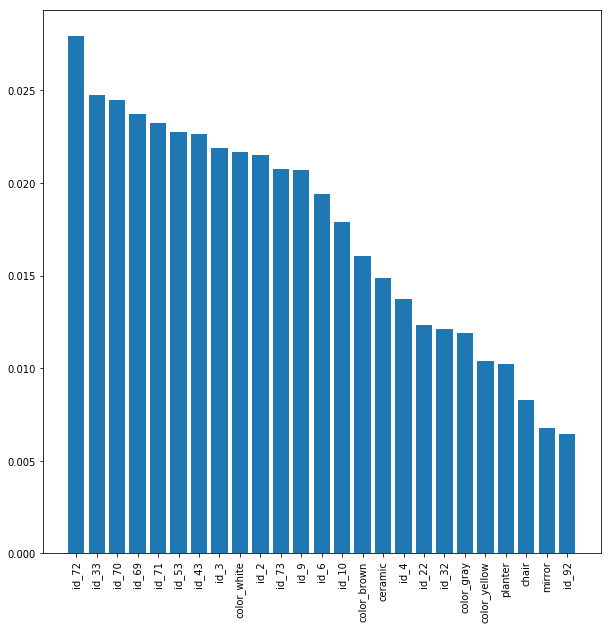


Coastal_style
[[7869  243]
 [ 217 2190]]
tn:  7869 fp:  243 fn:  217 tp:  2190
Precision is:  0.900123304562
Recall is:  0.909846281678
Accuracy is:  0.956269607377
                scores
color_white   0.047660
color_brown   0.037781
id_33         0.024625
color_yellow  0.021903
chair         0.018627
id_72         0.017590
color_gray    0.017420
id_3          0.016147
id_70         0.015527
id_69         0.014433
color_teal    0.013946
ceramic       0.013766
id_73         0.013396
id_43         0.012670
id_53         0.012463
id_92         0.012431
id_2          0.012430
color_green   0.011471
id_10         0.011172
color_blue    0.010979
id_107        0.010252
id_71         0.009396
id_6          0.009357
color_red     0.009119
id_9          0.009067


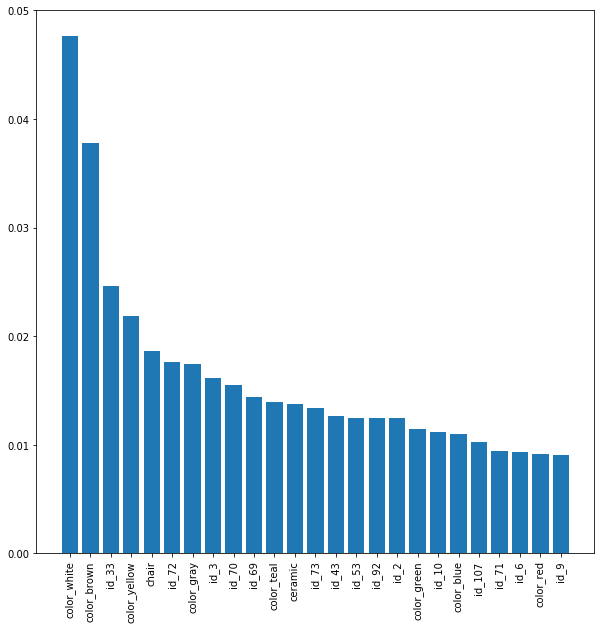


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [874]:
run_rfcs(df,style_cols,use_cols)

In [614]:
from sklearn.ensemble import AdaBoostClassifier

In [615]:
def test_ada(filtered_df,style_col,use_cols):
#     vectorizer = TfidfVectorizer(stop_words='english')
#     X = vectorizer.fit_transform(filtered_df['new_text'])
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)

    X_train, X_test, Y_train, Y_test = tts(X,y)
    ada = AdaBoostClassifier(n_estimators=200,learning_rate=0.01)
    ada.fit(X_train,Y_train)
    print style_col
    con_matrix(ada,X_test,Y_test)
    graph_it(ada,labels,use_cols)

def run_ada(df,style_cols,use_cols):
    for style_col in style_cols:
        filtered_df = filter_df_for_style(df,style_cols,style_col)
        tot = sum(list(df['target']))
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            test_ada(filtered_df,style_col,use_cols)
            print ""

### AdaBoost model
200 estimators
.01 learning rate
max_features used for vectorizor
colors used
1000 min labels

Mid-Century_style
[[6718  212]
 [1515  567]]
tn:  6718 fp:  212 fn:  1515 tp:  567
Precision is:  0.727856225931
Recall is:  0.272334293948
Accuracy is:  0.808366622281
           scores
specs       0.335
weight      0.215
vinyl       0.160
lead        0.125
hemp        0.090
planter     0.070
structure   0.005
00          0.000
000         0.000
001         0.000
0011        0.000
0012        0.000
0016        0.000
0017        0.000
0025        0.000
0026        0.000
0027        0.000
003         0.000
0035        0.000
004         0.000
005         0.000
01          0.000
012         0.000
015         0.000
01852       0.000


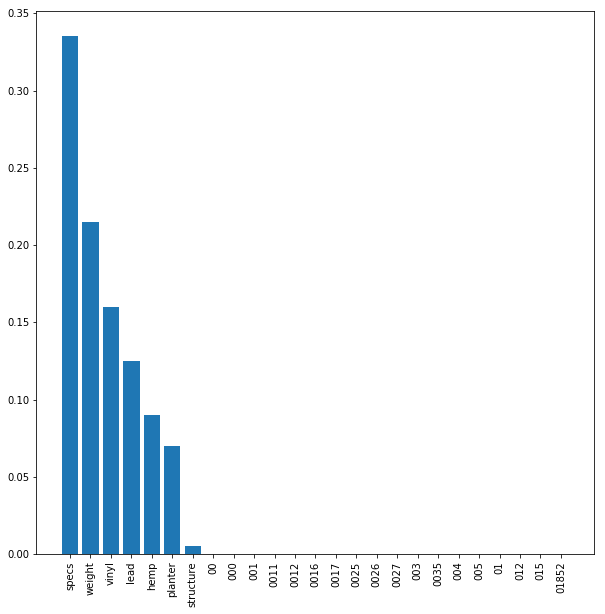


Rustic_style
[[5947   21]
 [2391  265]]
tn:  5947 fp:  21 fn:  2391 tp:  265
Precision is:  0.926573426573
Recall is:  0.0997740963855
Accuracy is:  0.720315398887
            scores
chair        0.395
ii           0.105
leather      0.105
max          0.065
planter      0.050
set          0.050
extra        0.045
lead         0.045
seat         0.040
ceramic      0.030
hemp         0.020
color_teal   0.020
vinyl        0.010
young        0.010
use          0.005
wooden       0.005
00           0.000
000          0.000
001          0.000
0011         0.000
0012         0.000
0016         0.000
0017         0.000
0025         0.000
0026         0.000


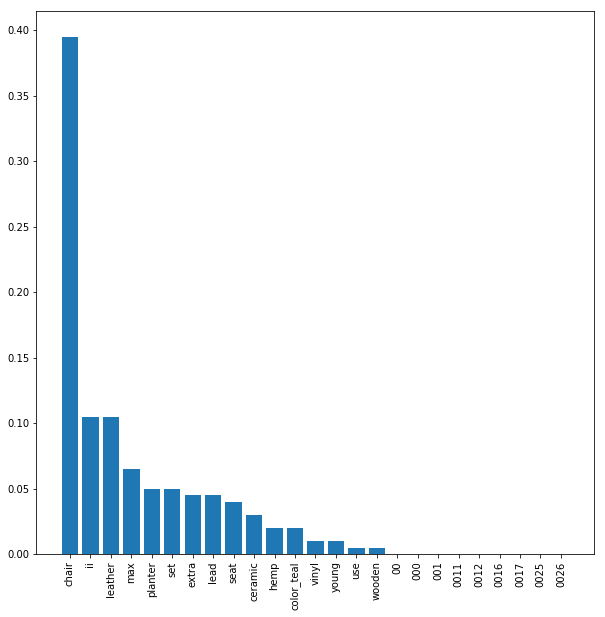


ArtsandCrafts_style
[[7193    4]
 [1287  171]]
tn:  7193 fp:  4 fn:  1287 tp:  171
Precision is:  0.977142857143
Recall is:  0.117283950617
Accuracy is:  0.850837666089
              scores
color_white    0.345
chair          0.195
vinyl          0.110
color_gray     0.080
planter        0.075
seat           0.065
hemp           0.060
color_yellow   0.030
weight         0.025
upholstered    0.015
00             0.000
000            0.000
001            0.000
0011           0.000
0012           0.000
0016           0.000
0017           0.000
0025           0.000
0026           0.000
0027           0.000
003            0.000
0035           0.000
004            0.000
005            0.000
01             0.000


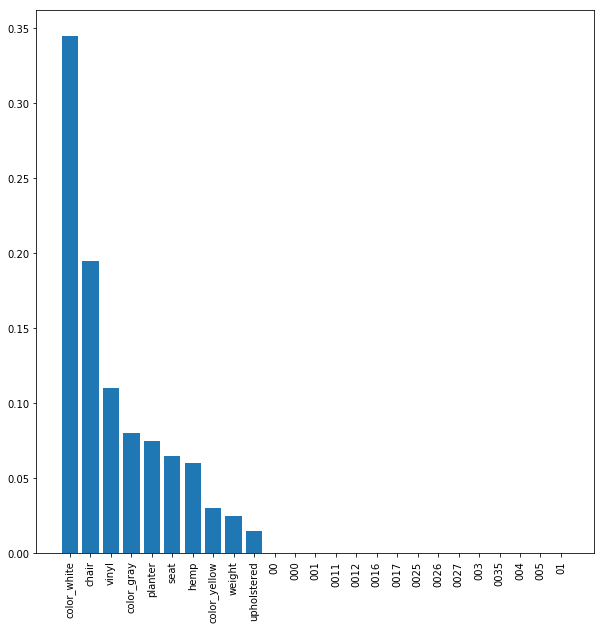


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[7926    3]
 [ 572   96]]
tn:  7926 fp:  3 fn:  572 tp:  96
Precision is:  0.969696969697
Recall is:  0.14371257485
Accuracy is:  0.933116203327
              scores
planter        0.245
color_yellow   0.235
chair          0.200
glass          0.135
color_white    0.085
vase           0.050
seat           0.030
max            0.010
specs          0.005
time           0.005
00             0.000
000            0.000
001            0.000
0011           0.000
0012           0.000
0016           0.000
0017           0.000
0025           0.000
0026           0.000
0027           0.000
003            0.000
0035           0.000
004            0.000
005            0.000
01             0.000


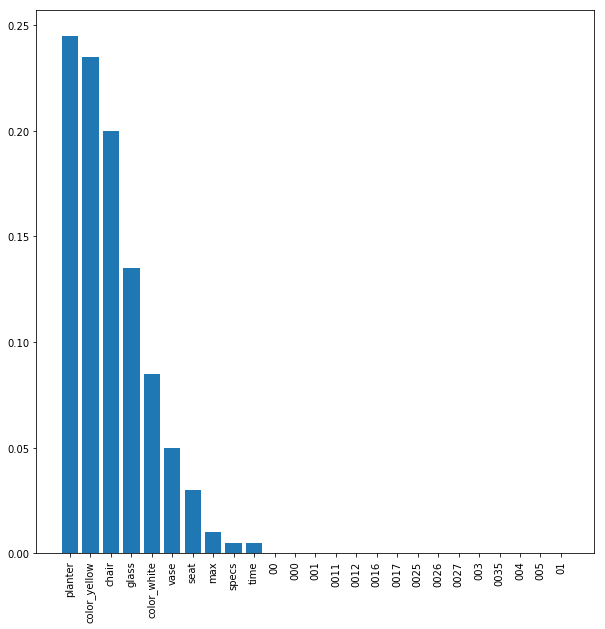


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[1894 1019]
 [   3 5785]]
tn:  1894 fp:  1019 fn:  3 tp:  5785
Precision is:  0.850235155791
Recall is:  0.999481686247
Accuracy is:  0.882542236525
             scores
set           0.245
weight        0.210
color_white   0.175
lead          0.170
min           0.110
specs         0.020
time          0.020
commercial    0.015
frame         0.015
shape         0.010
oil           0.005
strength      0.005
00            0.000
000           0.000
001           0.000
0011          0.000
0012          0.000
0016          0.000
0017          0.000
0025          0.000
0026          0.000
0027          0.000
003           0.000
0035          0.000
00

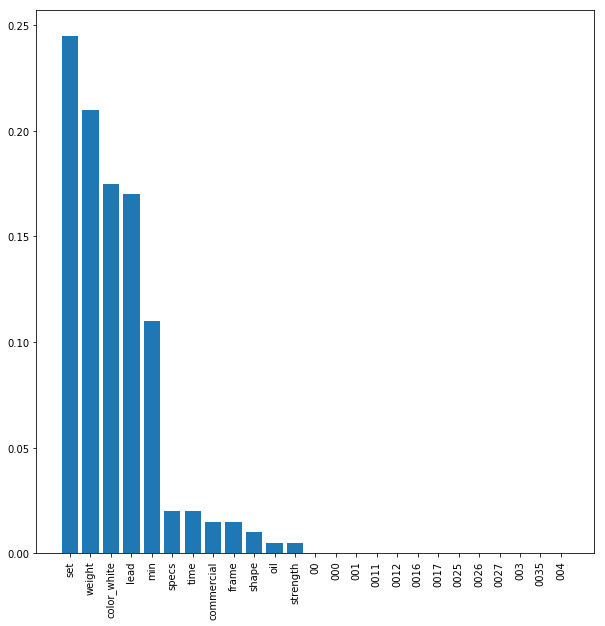


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[1986 2575]
 [  13 4615]]
tn:  1986 fp:  2575 fn:  13 tp:  4615
Precision is:  0.641863699583
Recall is:  0.997191011236
Accuracy is:  0.718358907389
             scores
color_white   0.245
lead          0.215
ii            0.135
weight        0.115
use           0.105
color_brown   0.075
color_teal    0.035
min           0.030
century       0.020
set           0.015
structure     0.005
young         0.005
00            0.000
000           0.000
001           0.000
0011          0.000
0012          0.000
0016          0.000
0017          0.000
0025          0.000
0026          0.000
0027          0.000
003           0.000
0035          0.000
004           0.000


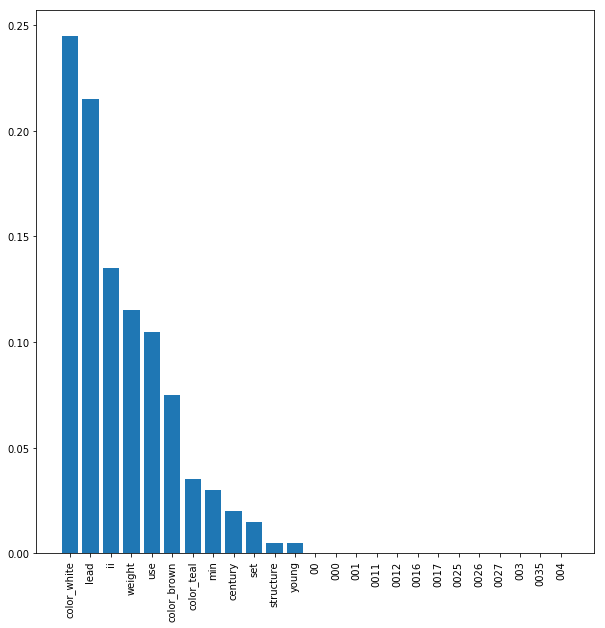


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[7916    4]
 [ 567  110]]
tn:  7916 fp:  4 fn:  567 tp:  110
Precision is:  0.964912280702
Recall is:  0.162481536189
Accuracy is:  0.933581481912
              scores
planter        0.240
color_yellow   0.230
chair          0.205
glass          0.145
color_white    0.090
seat           0.035
vase           0.035
max            0.010
12             0.005
specs          0.005
00             0.000
000            0.000
001            0.000
0011           0.000
0012           0.000
0016           0.000
0017           0.000
0025           0.000
0026           0.000
0027           0.000
003            0.000
0035           0.000
004            0.000
005            0.000
01             0.000


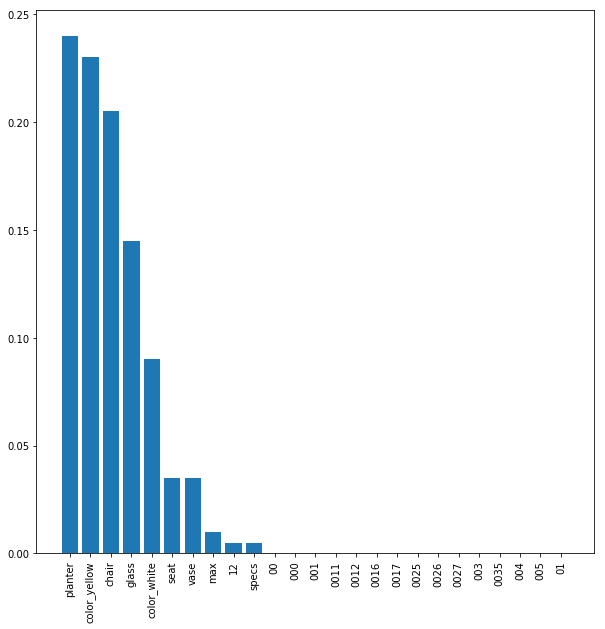


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[4870  916]
 [1286 1555]]
tn:  4870 fp:  916 fn:  1286 tp:  1555
Precision is:  0.629299878592
Recall is:  0.54734248504
Accuracy is:  0.744754839458
             scores
chair         0.420
seat          0.125
color_black   0.115
lead          0.105
weight        0.085
color_white   0.075
upholstered   0.050
vinyl         0.015
color_teal    0.010
00            0.000
000           0.000
001           0.000
0011          0.000
0012          0.000
0016          0.000
0017          0.000
0025          0.000
0026          0.000
0027          0.000
003           0.000
0035          0.000
004           0.000
005           0.000
01            0.000
012           0.000


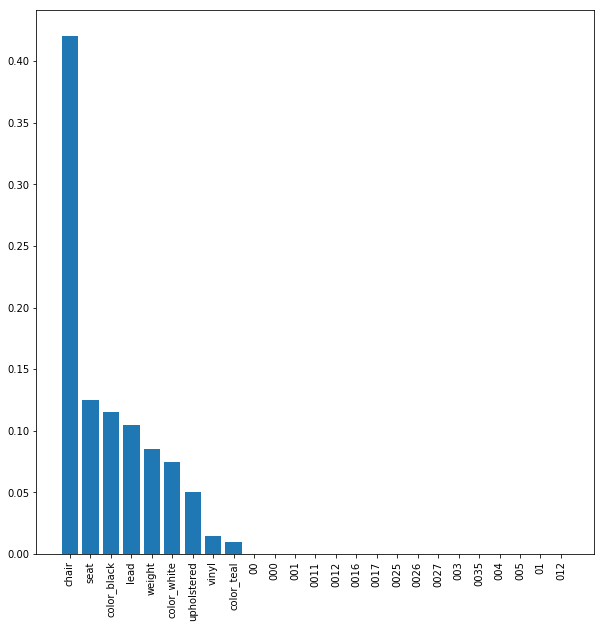


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[5057    6]
 [1678 1968]]
tn:  5057 fp:  6 fn:  1678 tp:  1968
Precision is:  0.996960486322
Recall is:  0.539769610532
Accuracy is:  0.806636812493
              scores
lead           0.240
weight         0.240
planter        0.145
ceramic        0.125
specs          0.095
color_red      0.065
color_yellow   0.060
commercial     0.015
foam           0.005
strength       0.005
vinyl          0.005
00             0.000
000            0.000
001            0.000
0011           0.000
0012           0.000
0016           0.000
0017           0.000
0025           0.000
0026           0.000
0027           0.000
003            0.000
0035           0.000
004            0.000
005            0.000


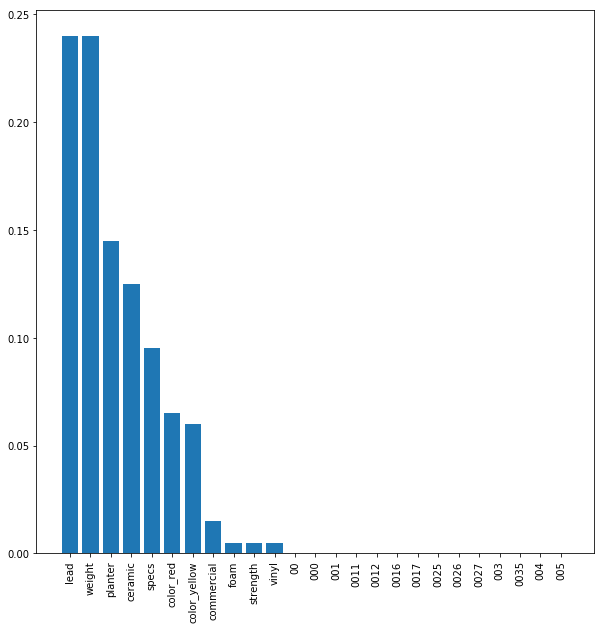


Contemporary_style
[[ 142 1034]
 [   0 7716]]
tn:  142 fp:  1034 fn:  0 tp:  7716
Precision is:  0.881828571429
Recall is:  1.0
Accuracy is:  0.883715699505
            scores
set          0.210
leather      0.175
chairs       0.145
wooden       0.125
oil          0.070
specs        0.070
max          0.045
bradington   0.035
metal        0.035
painted      0.035
young        0.025
time         0.015
weight       0.015
00           0.000
000          0.000
001          0.000
0011         0.000
0012         0.000
0016         0.000
0017         0.000
0025         0.000
0026         0.000
0027         0.000
003          0.000
0035         0.000


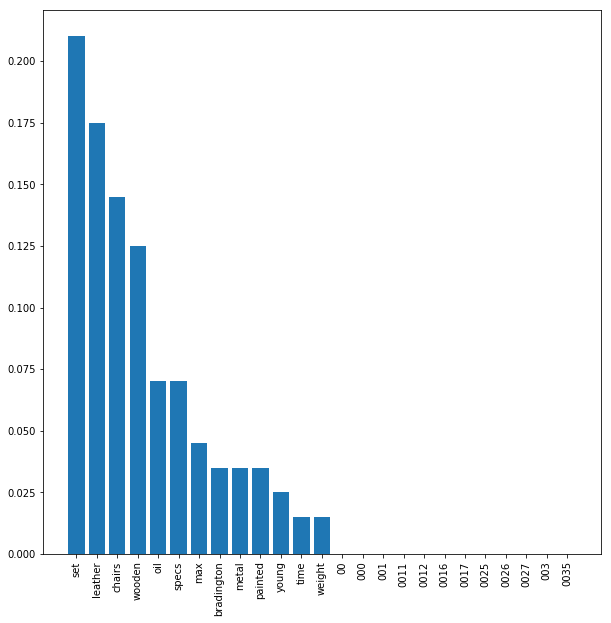


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[6990    2]
 [1523  159]]
tn:  6990 fp:  2 fn:  1523 tp:  159
Precision is:  0.987577639752
Recall is:  0.0945303210464
Accuracy is:  0.824187226193
             scores
vinyl         0.165
color_gray    0.135
weight        0.120
hemp          0.100
chair         0.095
seat          0.085
color_white   0.085
lead          0.070
ceramic       0.060
planter       0.045
upholstered   0.030
specs         0.005
use           0.005
00            0.000
000           0.000
001           0.000
0011          0.000
0012          0.000
0016          0.000
0017          0.000
0025          0.000
0026          0.000
0027          0.000
003           0.000
0035          0.000


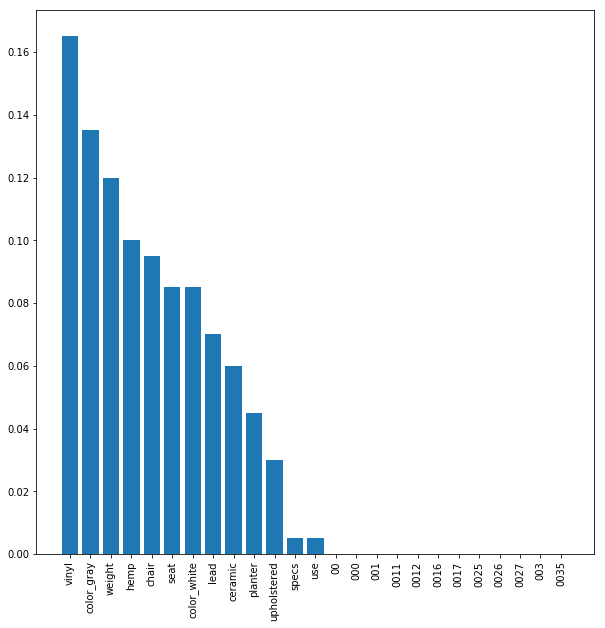


Coastal_style
[[5567  748]
 [ 842 1599]]
tn:  5567 fp:  748 fn:  842 tp:  1599
Precision is:  0.681295270558
Recall is:  0.655059401884
Accuracy is:  0.818410232983
             scores
color_white   0.405
chair         0.260
lead          0.135
seat          0.130
specs         0.030
upholstered   0.020
ceramic       0.010
color_brown   0.010
00            0.000
000           0.000
001           0.000
0011          0.000
0012          0.000
0016          0.000
0017          0.000
0025          0.000
0026          0.000
0027          0.000
003           0.000
0035          0.000
004           0.000
005           0.000
01            0.000
012           0.000
015           0.000


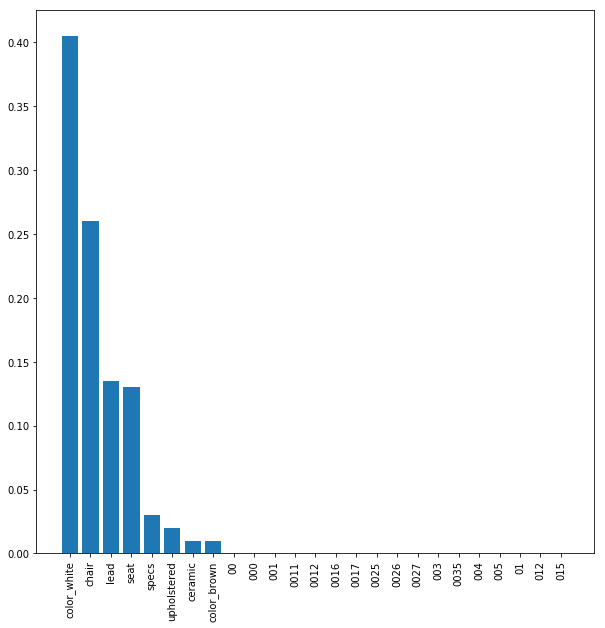


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [617]:
run_ada(df,style_cols,use_cols)

In [623]:
from sklearn.ensemble import GradientBoostingClassifier

In [638]:
def run_gbt(df,style_cols,use_cols):
    for style_col in style_cols:
        filtered_df = filter_df_for_style(df,style_cols,style_col)
        tot = sum(list(df['target']))
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            test_gbt(filtered_df,style_col,use_cols)
            print ""

def test_gbt(filtered_df,style_col,use_cols):
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)
    X_train, X_test, Y_train, Y_test = tts(X,y)
    gbt = GradientBoostingClassifier(n_estimators=200,learning_rate=0.01)
    gbt.fit(X_train,Y_train)
    print style_col
    con_matrix(gbt,X_test,Y_test)
    graph_it(gbt,labels,use_cols)

### Gradient Boosting Tree Classifier
200 estimators
.01 learning rate
max_features
used colors


Mid-Century_style
[[8385    8]
 [1821  305]]
tn:  8385 fp:  8 fn:  1821 tp:  305
Precision is:  0.974440894569
Recall is:  0.143461900282
Accuracy is:  0.826124156289
                scores
vinyl         0.142802
hemp          0.117076
specs         0.104372
weight        0.097923
planter       0.080555
color_brown   0.052998
cor           0.049399
limited       0.045813
japanese      0.045292
grass         0.040764
color_white   0.033326
silk          0.031200
seat          0.027931
vase          0.021177
orchids       0.017440
glass         0.014999
leather       0.013418
m2            0.013170
palm          0.009992
pearl         0.006915
yellow        0.006391
wide          0.004671
color_yellow  0.004258
color_teal    0.003227
color_gray    0.002678


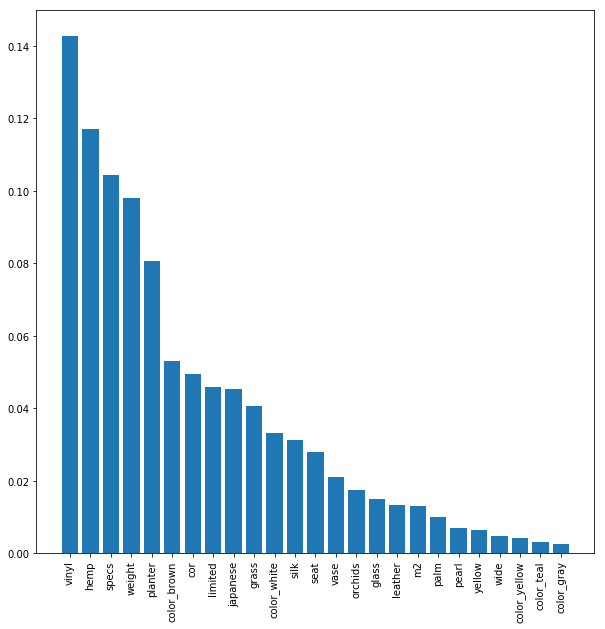


Rustic_style
[[7861   31]
 [2289  338]]
tn:  7861 fp:  31 fn:  2289 tp:  338
Precision is:  0.915989159892
Recall is:  0.128663875143
Accuracy is:  0.779446715467
               scores
chair        0.122382
seat         0.090773
specs        0.081353
ii           0.076879
max          0.062143
set          0.060729
leather      0.057312
wooden       0.054962
12           0.041199
planter      0.040682
color_teal   0.039796
ceramic      0.039398
glass        0.034995
mc           0.029357
vinyl        0.027409
iii          0.017712
metal        0.013679
color_blue   0.011063
color_brown  0.009697
hemp         0.009590
palm         0.008768
color_gray   0.008254
iv           0.007743
love         0.005920
chairs       0.005118


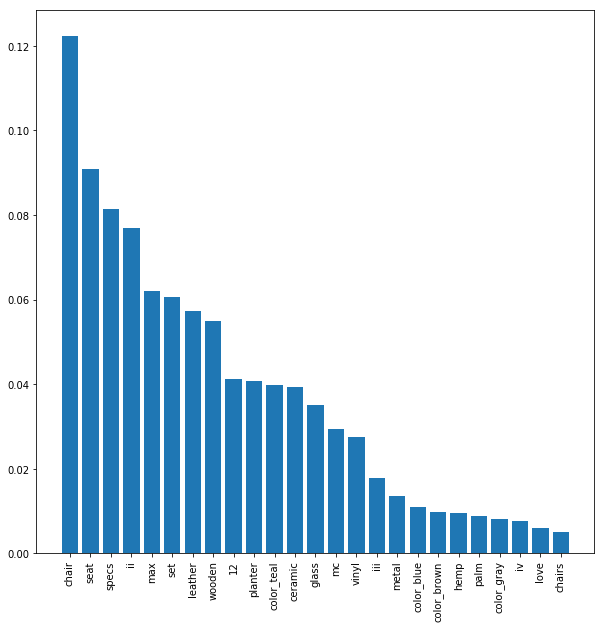


ArtsandCrafts_style
[[9087   11]
 [1032  389]]
tn:  9087 fp:  11 fn:  1032 tp:  389
Precision is:  0.9725
Recall is:  0.273750879662
Accuracy is:  0.900846088031
                scores
color_white   0.237792
hemp          0.115056
vinyl         0.112645
planter       0.082622
chair         0.069034
japanese      0.051306
grass         0.049281
color_gray    0.046036
limited       0.043434
color_yellow  0.037455
glass         0.035018
color_brown   0.021990
orchids       0.016972
silk          0.010947
bracket       0.009206
vase          0.009007
palm          0.008238
indoor        0.007714
yellow        0.007588
seat          0.005911
embroidered   0.005901
pearl         0.003934
02            0.003127
weaves        0.002768
louisa        0.001882


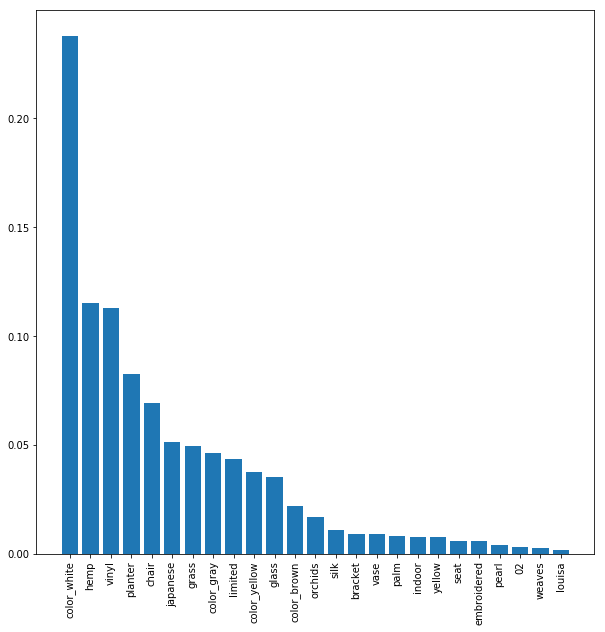


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9833   11]
 [ 508  167]]
tn:  9833 fp:  11 fn:  508 tp:  167
Precision is:  0.938202247191
Recall is:  0.247407407407
Accuracy is:  0.950660709193
                scores
planter       0.278505
color_yellow  0.123348
glass         0.075391
orchids       0.066374
bracket       0.063047
color_white   0.049871
vase          0.046842
color_brown   0.034910
ball          0.030223
chair         0.029727
palm          0.029610
yellow        0.023733
finial        0.014811
urn           0.013490
orchid        0.013064
mixed         0.012588
specs         0.011832
succulents    0.010199
order         0.009684
pearl         0.008450
stem          0.008357
basket        0.004542
boxwood       0.004450
maison        0.004439
seniah        0.00

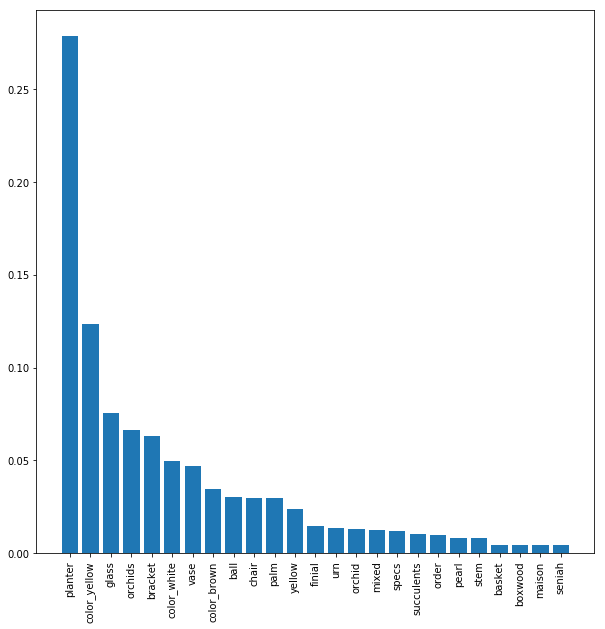


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[2742 1934]
 [ 355 5488]]
tn:  2742 fp:  1934 fn:  355 tp:  5488
Precision is:  0.739423336028
Recall is:  0.939243539278
Accuracy is:  0.782393763666
                scores
color_white   0.186919
12            0.162514
seat          0.115270
weight        0.106966
lead          0.089515
specs         0.086904
century       0.053243
set           0.043919
leather       0.035633
wooden        0.019172
painting      0.017805
11            0.013927
14            0.012602
metal         0.011345
oil           0.009573
inches        0.005568
ottoman       0.004308
min           0.002976
sofa          0.002508
love          0.002352
color_yellow  0.0

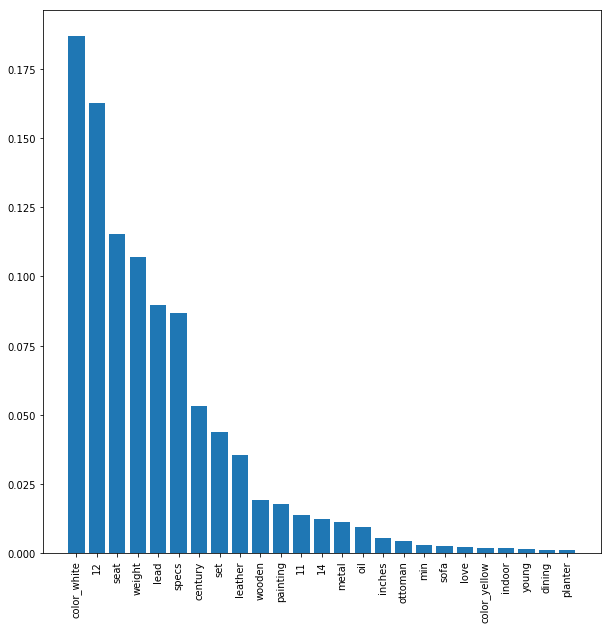


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[4491 1357]
 [1284 3387]]
tn:  4491 fp:  1357 fn:  1284 tp:  3387
Precision is:  0.713954468803
Recall is:  0.725112395633
Accuracy is:  0.748930506702
                scores
color_white   0.261714
weight        0.138177
12            0.117745
specs         0.048496
color_brown   0.040059
ii            0.038982
lead          0.038519
century       0.028472
color_gray    0.028262
color_teal    0.025394
young         0.019971
bradington    0.018150
set           0.016708
oil           0.015946
custom        0.015624
30            0.012155
slipcovered   0.012005
vinyl         0.011417
wall          0.011072
use           0.010929
color_yellow  0.009166
ottoman       0.008021
wooden        0.007548
metal         0.007208
room          0.007167


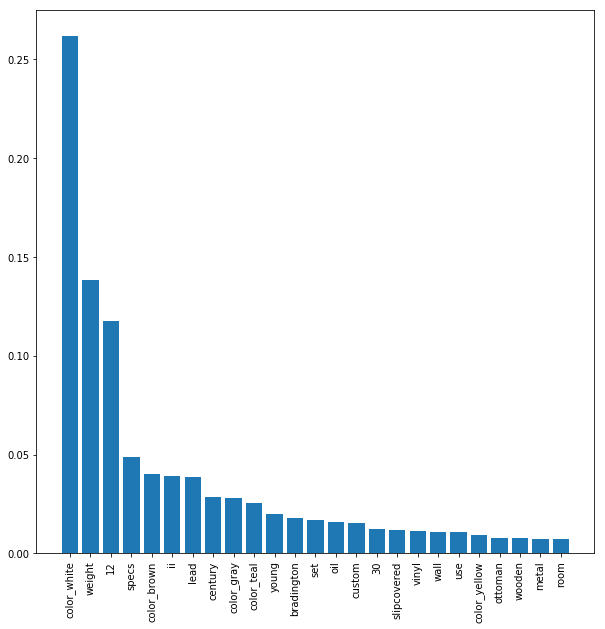


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[9859    4]
 [ 490  166]]
tn:  9859 fp:  4 fn:  490 tp:  166
Precision is:  0.976470588235
Recall is:  0.253048780488
Accuracy is:  0.953037360966
                scores
planter       0.267319
color_yellow  0.121211
glass         0.063790
bracket       0.063157
orchids       0.059419
color_white   0.049225
vase          0.048636
color_brown   0.037576
ball          0.037411
chair         0.034766
palm          0.030415
succulents    0.021982
yellow        0.021534
pearl         0.015894
finial        0.012798
color_teal    0.012719
vanda         0.012603
basket        0.010822
specs         0.008878
greenguard    0.007573
urn           0.007333
stud          0.005829
color_gray    0.004414
orchid        0.004307
color_green   0.003241


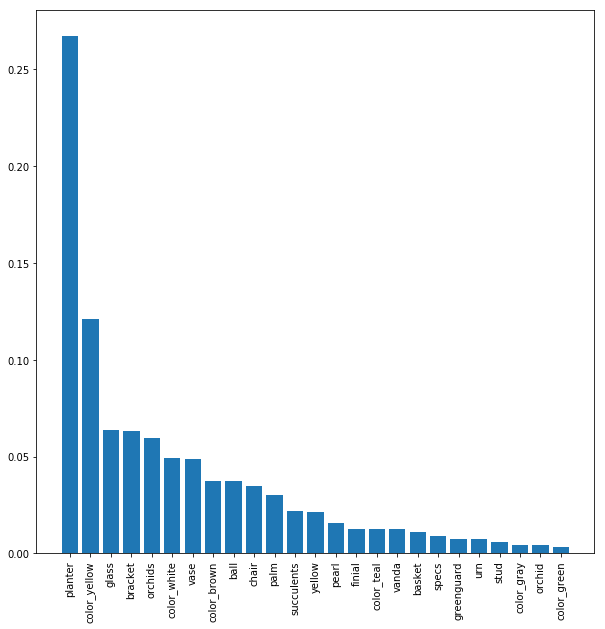


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[7581   34]
 [2319  585]]
tn:  7581 fp:  34 fn:  2319 tp:  585
Precision is:  0.9450726979
Recall is:  0.201446280992
Accuracy is:  0.776309535127
                scores
chair         0.246829
seat          0.106889
color_white   0.081801
ii            0.073813
specs         0.067921
color_black   0.060654
vinyl         0.052805
hemp          0.048853
color_teal    0.041179
planter       0.026902
sofa          0.021800
wooden        0.019311
set           0.017957
ceramic       0.017610
m2            0.017302
color_yellow  0.016197
12            0.010703
color_brown   0.009963
white         0.007285
glass         0.006721
custom        0.006458
mirror        0.006116
palm          0.003404
dining        0.002980
loveseat      0.002955


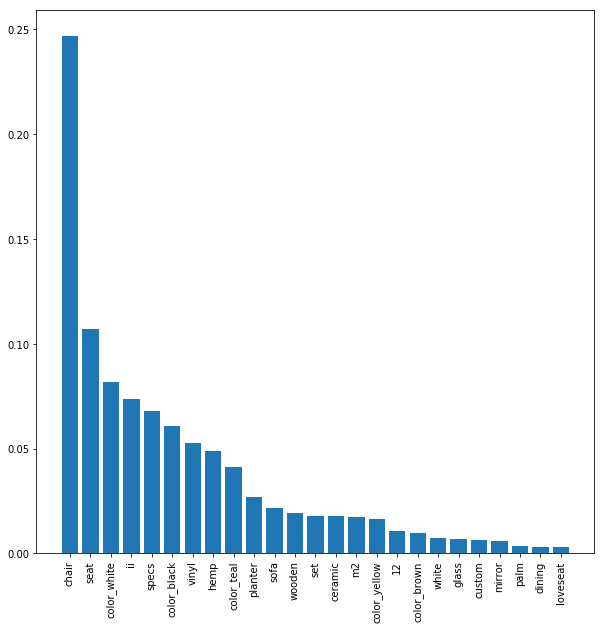


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[6978    9]
 [1541 1991]]
tn:  6978 fp:  9 fn:  1541 tp:  1991
Precision is:  0.9955
Recall is:  0.563703284258
Accuracy is:  0.852647590075
                scores
lead          0.666512
weight        0.104535
ceramic       0.027817
color_red     0.027276
planter       0.027070
specs         0.026325
color_yellow  0.021830
glass         0.021743
bracket       0.014512
color_green   0.012932
vase          0.010143
finial        0.008927
orchids       0.007487
palm          0.003784
moore         0.003100
chair         0.002998
ii            0.002318
figure        0.002206
abstract      0.002043
color_brown   0.001809
depth         0.001287
ceiling       0.000387
globe         0.000271
leader        0.000174
exposed       0.000157


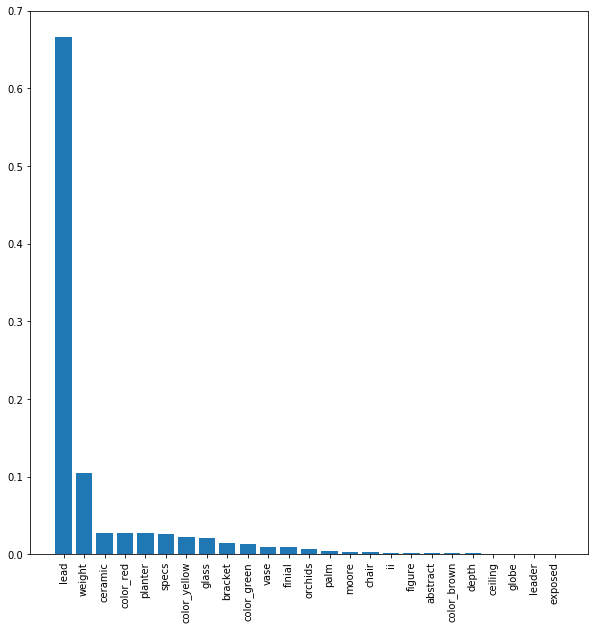


Contemporary_style
[[ 524 2286]
 [  67 7642]]
tn:  524 fp:  2286 fn:  67 tp:  7642
Precision is:  0.769742143433
Recall is:  0.991308859774
Accuracy is:  0.776309535127
               scores
specs        0.147616
century      0.131492
time         0.127052
max          0.098765
chair        0.079734
leather      0.079513
young        0.070505
bradington   0.065495
inches       0.059063
color_white  0.029206
oil          0.022635
set          0.022474
chairs       0.018168
painting     0.017142
weight       0.013951
custom       0.002836
palm         0.001638
game         0.001389
lounge       0.001377
color_brown  0.001232
sleeper      0.000894
peter        0.000754
panels       0.000541
series       0.000517
sectional    0.000517


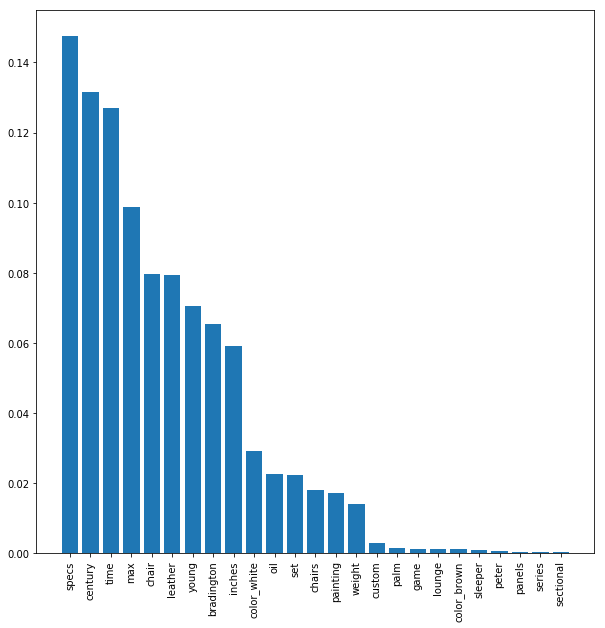


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[8807   14]
 [1320  378]]
tn:  8807 fp:  14 fn:  1320 tp:  378
Precision is:  0.964285714286
Recall is:  0.222614840989
Accuracy is:  0.873181861394
               scores
vinyl        0.142996
hemp         0.105255
color_white  0.099311
planter      0.076519
seat         0.062497
color_gray   0.059733
ceramic      0.059255
japanese     0.055183
white        0.050847
grass        0.049327
chair        0.044674
glass        0.037872
limited      0.032942
specs        0.030583
vase         0.011863
silk         0.011303
color_teal   0.010353
pearl        0.006749
weave        0.005702
yellow       0.005534
dining       0.005528
palm         0.004837
color_brown  0.003827
lounge       0.003331
weaves       0.003262


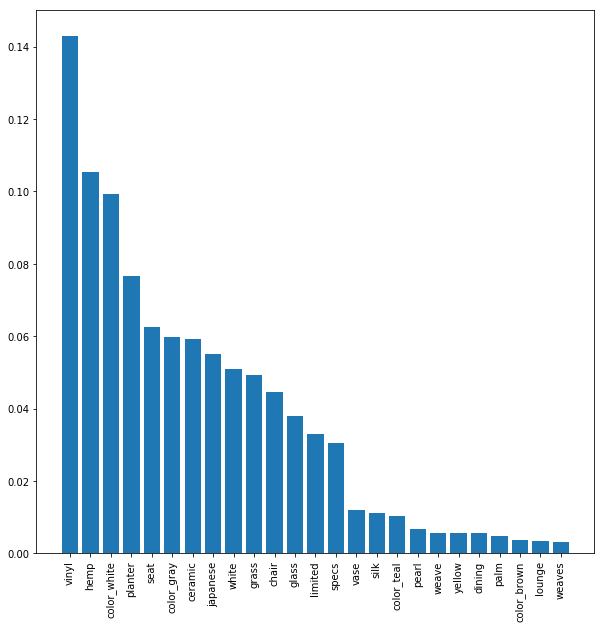


Coastal_style
[[7257  862]
 [ 587 1813]]
tn:  7257 fp:  862 fn:  587 tp:  1813
Precision is:  0.677757009346
Recall is:  0.755416666667
Accuracy is:  0.862249263238
                scores
color_white   0.367757
chair         0.137996
seat          0.083925
specs         0.056746
ceramic       0.050769
wooden        0.042213
planter       0.040722
hemp          0.039275
color_brown   0.035357
glass         0.031718
color_yellow  0.025273
vinyl         0.024343
white         0.011900
color_gray    0.008044
metal         0.007086
sofa          0.006981
ii            0.005365
pearl         0.003621
moore         0.003165
grass         0.002830
limited       0.002638
casual        0.002201
ladder        0.001448
stripe        0.001078
polywood      0.001075


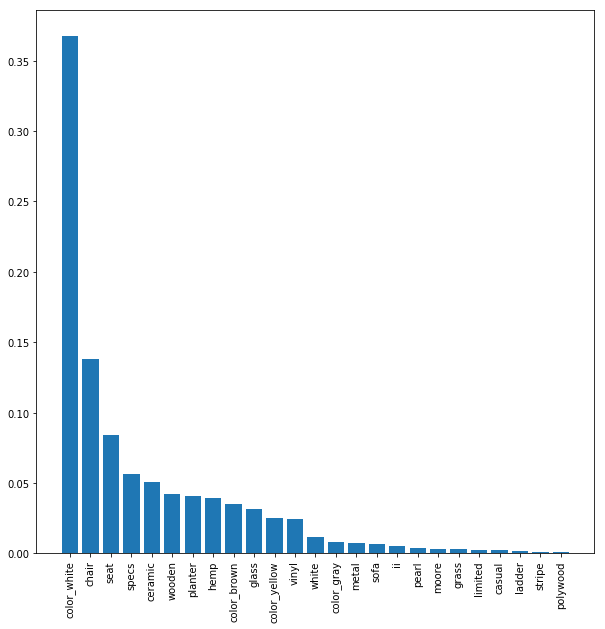


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [639]:
run_gbt(df,style_cols,use_cols)

In [640]:
import xgboost

In [643]:
def run_xgb(df,style_cols,use_cols):
    for style_col in style_cols:
        filtered_df = filter_df_for_style(df,style_cols,style_col)
        tot = sum(list(df['target']))
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            test_xgb(filtered_df,style_col,use_cols)
            print ""

def test_xgb(filtered_df,style_col,use_cols):
#     vectorizer = TfidfVectorizer(stop_words='english')
#     X = vectorizer.fit_transform(filtered_df['new_text'])
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)

    X_train, X_test, Y_train, Y_test = tts(X,y)
    xgb = xgboost.XGBClassifier(n_estimators=1000,learning_rate=0.001)
    xgb.fit(X_train,Y_train)
    print style_col
    con_matrix(xgb,X_test,Y_test)
    graph_it(xgb,labels,use_cols)

### XGboost model
1000 estimators,
.001 learning rate.
max_features, and color used


Mid-Century_style
[[8488   17]
 [1717  297]]
tn:  8488 fp:  17 fn:  1717 tp:  297
Precision is:  0.945859872611
Recall is:  0.147467725919
Accuracy is:  0.835155433026
               scores
weight       0.209458
vinyl        0.145559
pearl        0.112111
specs        0.100115
hemp         0.097116
color_brown  0.073356
planter      0.069666
chair        0.055825
yellow       0.045213
limited      0.021915
japanese     0.020992
lead         0.015686
style        0.015686
min          0.006690
inches       0.005536
color_white  0.004614
accent       0.000231
color_gray   0.000231
00           0.000000
000          0.000000
001          0.000000
0011         0.000000
0012         0.000000
0016         0.000000
0017         0.000000


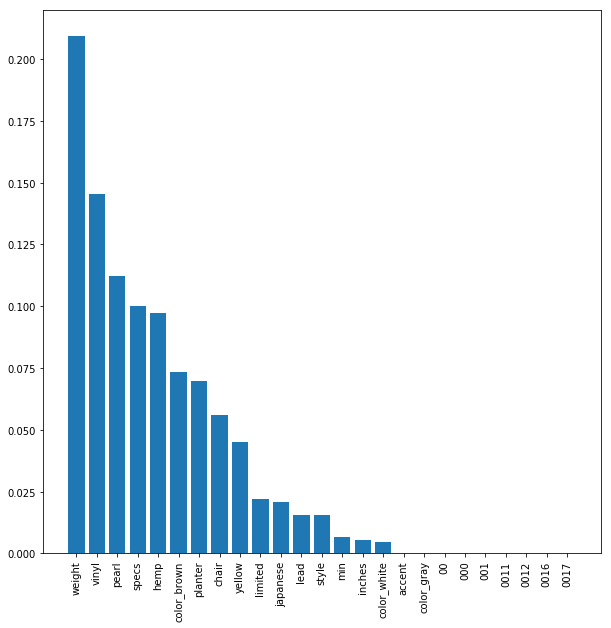


Rustic_style
[[7891   22]
 [2423  183]]
tn:  7891 fp:  22 fn:  2423 tp:  183
Precision is:  0.892682926829
Recall is:  0.0702225633154
Accuracy is:  0.767563456602
                scores
chair         0.261882
specs         0.116100
time          0.067631
ii            0.061244
love          0.053166
seat          0.053166
color_yellow  0.052790
linen         0.047717
max           0.047717
set           0.039639
barstool      0.036070
planter       0.029495
hooker        0.019350
finish        0.017096
wooden        0.013902
12            0.013338
mount         0.013338
dining        0.012023
color_brown   0.006951
pulley        0.006200
faux          0.006012
leather       0.006012
vintage       0.006012
color_white   0.004133
stand         0.003194


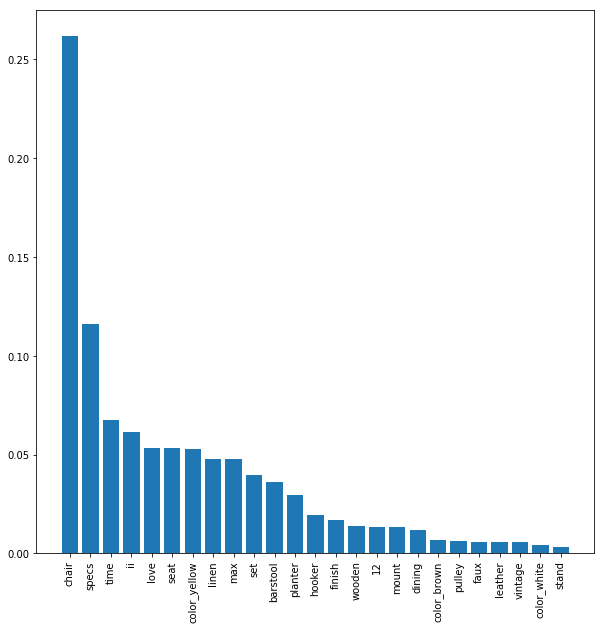


ArtsandCrafts_style
[[9033   21]
 [1092  373]]
tn:  9033 fp:  21 fn:  1092 tp:  373
Precision is:  0.946700507614
Recall is:  0.254607508532
Accuracy is:  0.894191463067
                scores
color_white   0.144009
hemp          0.108871
glass         0.104263
planter       0.101671
vinyl         0.093174
palm          0.089142
pearl         0.077621
chair         0.074885
color_yellow  0.069844
color_orange  0.040467
color_brown   0.029666
color_gray    0.018865
japanese      0.012673
yellow        0.011089
vase          0.010225
limited       0.006768
shagreen      0.006768
00            0.000000
000           0.000000
001           0.000000
0011          0.000000
0012          0.000000
0016          0.000000
0017          0.000000
0025          0.000000


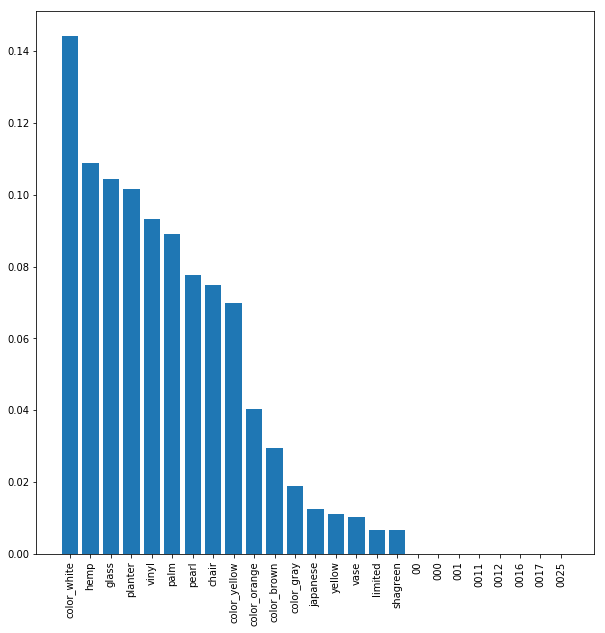


Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9858   11]
 [ 498  152]]
tn:  9858 fp:  11 fn:  498 tp:  152
Precision is:  0.932515337423
Recall is:  0.233846153846
Accuracy is:  0.951611369902
                scores
color_yellow  0.169341
planter       0.157585
palm          0.127085
glass         0.110564
specs         0.093566
color_white   0.090548
bracket       0.079428
vase          0.044162
color_brown   0.042732
indoor        0.028435
color_green   0.015727
vanda         0.010167
orchids       0.010008
pearl         0.006513
yes           0.005242
mirror        0.004766
concrete      0.004130
00            0.000000
000           0.000000
001           0.000000
0011          0.000000
0012          0.000000
0016          0.000000
0017          0.000000
0025          0.00

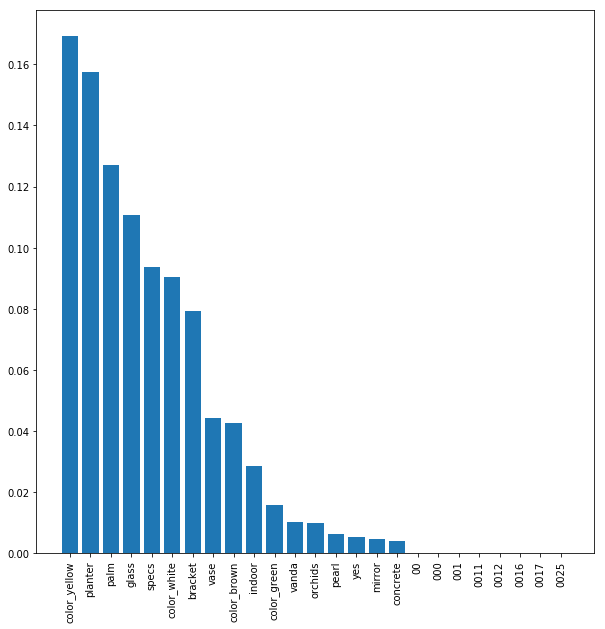


Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_style training set

Transitional_style
[[2767 1986]
 [ 342 5424]]
tn:  2767 fp:  1986 fn:  342 tp:  5424
Precision is:  0.731983805668
Recall is:  0.940686784599
Accuracy is:  0.7786861869
               scores
specs        0.170684
inches       0.149973
century      0.138904
weight       0.112480
lead         0.086770
medium       0.079093
color_white  0.050884
min          0.048027
time         0.045171
set          0.042849
12           0.033208
54           0.017497
14           0.012141
base         0.005535
total        0.003571
alder        0.002857
85           0.000357
00           0.000000
000          0.000000
001          0.000000
0011         0.000000
0012         0.000

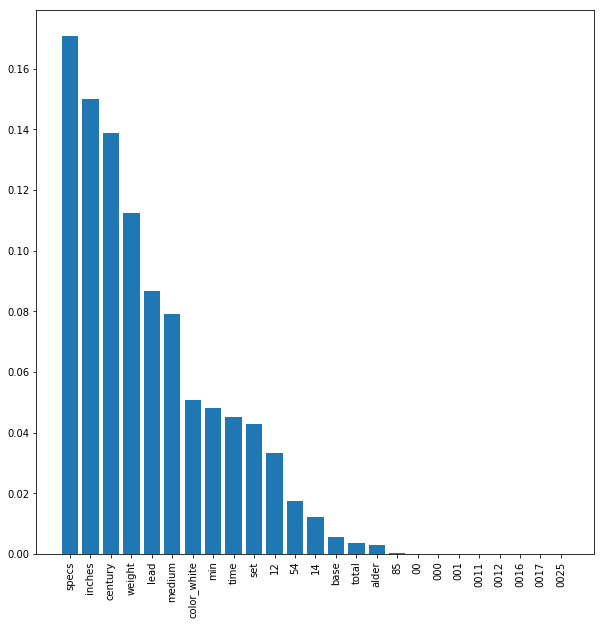


Solid_style Too small. Only 131 items classified as Solid_style training set

Tribal_style Too small. Only 1 items classified as Tribal_style training set

Traditional_style
[[4702 1088]
 [1797 2932]]
tn:  4702 fp:  1088 fn:  1797 tp:  2932
Precision is:  0.729353233831
Recall is:  0.620004229224
Accuracy is:  0.725734385398
               scores
color_white  0.107620
weight       0.092498
39           0.085625
lead         0.085625
time         0.085625
color_brown  0.079733
specs        0.075609
set          0.069521
custom       0.058916
bradington   0.057738
ii           0.041634
century      0.038688
color_gray   0.026905
color_teal   0.018068
12           0.013551
54           0.013551
depth        0.011980
wall         0.007659
color_blue   0.007266
oil          0.007070
max          0.004713
ottoman      0.004713
chandelier   0.002553
console      0.001571
lbs          0.001178


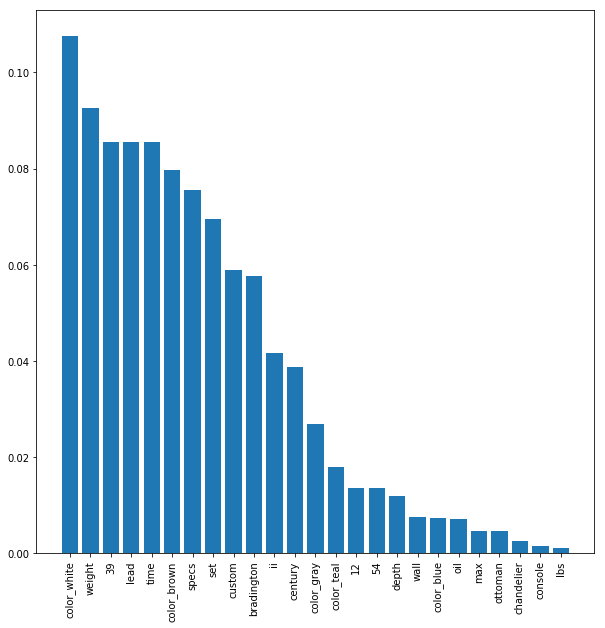


Victorian_style Too small. Only 1 items classified as Victorian_style training set

ArtNouveau_style Too small. Only 4 items classified as ArtNouveau_style training set

HollywoodRegency_style
[[9845   11]
 [ 511  152]]
tn:  9845 fp:  11 fn:  511 tp:  152
Precision is:  0.932515337423
Recall is:  0.229260935143
Accuracy is:  0.95037551098
                scores
planter       0.158140
palm          0.153488
color_yellow  0.146752
color_white   0.119006
glass         0.112911
specs         0.091740
indoor        0.057418
vase          0.047474
bracket       0.043304
color_brown   0.024539
boxwood       0.015557
vanda         0.010746
ball          0.009623
orchids       0.003208
ceiling       0.002727
ceramic       0.002245
stem          0.001123
00            0.000000
000           0.000000
001           0.000000
0011          0.000000
0012          0.000000
0016          0.000000
0017          0.000000
0025          0.000000


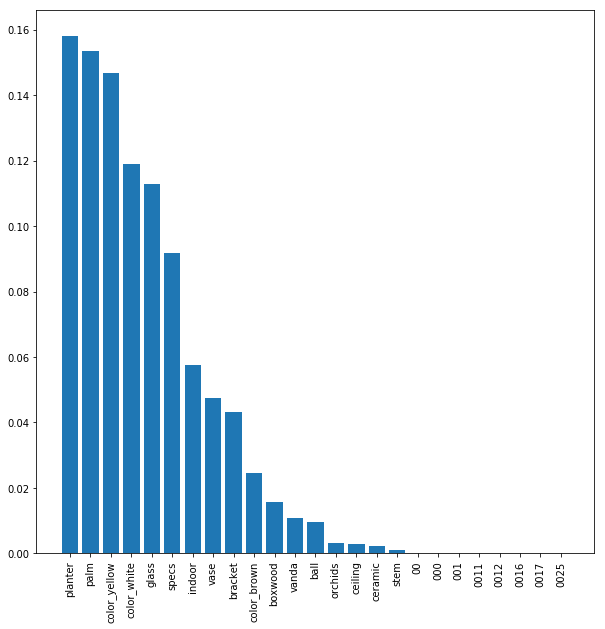


Baroque_style Too small. Only 1 items classified as Baroque_style training set

Woven_style Too small. Only 1 items classified as Woven_style training set

Prints_style Too small. Only 14 items classified as Prints_style training set

Industrial_style
[[7544   58]
 [2588  329]]
tn:  7544 fp:  58 fn:  2588 tp:  329
Precision is:  0.850129198966
Recall is:  0.112787110045
Accuracy is:  0.748455176348
                scores
chair         0.142857
m2            0.142857
color_white   0.087429
specs         0.083143
seat          0.077429
dining        0.063429
club          0.055714
color_gray    0.047571
brown         0.047429
custom        0.043571
30            0.035143
barstool      0.031857
color_yellow  0.026714
color_brown   0.024286
color_black   0.022143
grey          0.020000
finish        0.019714
vinyl         0.015571
ii            0.007571
color_teal    0.005571
00            0.000000
000           0.000000
001           0.000000
0011          0.000000
0012          0.000000

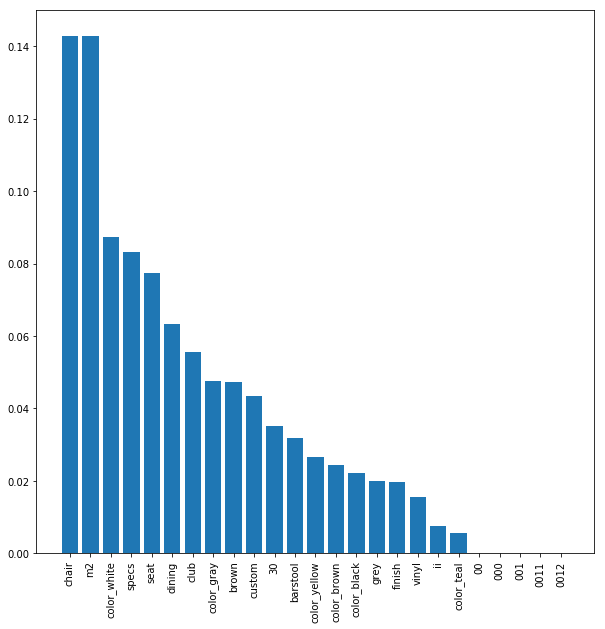


Classic_style Too small. Only 8 items classified as Classic_style training set

Abstract_style Too small. Only 12 items classified as Abstract_style training set

Modern_style
[[6902    5]
 [1666 1946]]
tn:  6902 fp:  5 fn:  1666 tp:  1946
Precision is:  0.997437211686
Recall is:  0.538759689922
Accuracy is:  0.841144595494
                scores
specs         0.178453
12            0.168907
lead          0.168907
planter       0.101500
palm          0.081434
ceramic       0.064290
color_yellow  0.057666
glass         0.043055
abstract      0.037600
weight        0.025911
color_green   0.025911
color_red     0.022014
color_brown   0.009546
vase          0.008377
drawing       0.006429
00            0.000000
000           0.000000
001           0.000000
0011          0.000000
0012          0.000000
0016          0.000000
0017          0.000000
0025          0.000000
0026          0.000000
0027          0.000000


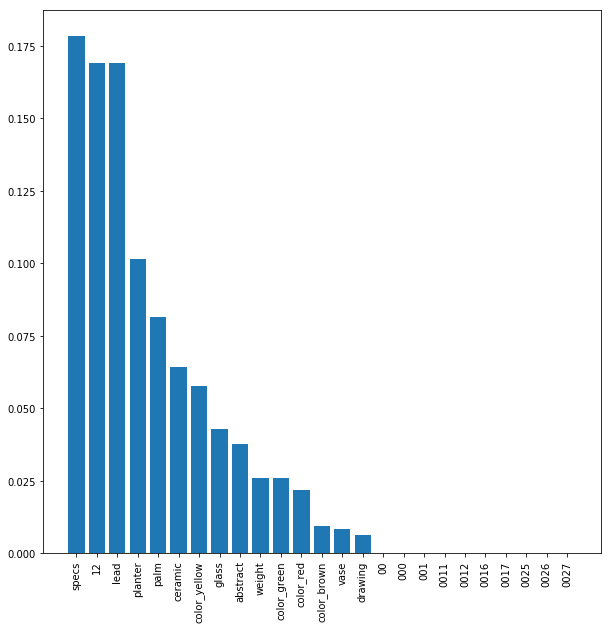


Contemporary_style
[[ 507 2324]
 [  49 7639]]
tn:  507 fp:  2324 fn:  49 tp:  7639
Precision is:  0.766736926629
Recall is:  0.993626430801
Accuracy is:  0.774408213709
              scores
time        0.239163
specs       0.148942
bradington  0.132812
century     0.121472
chair       0.095010
19          0.079889
inches      0.054688
arm         0.035534
20th        0.026714
modern      0.014869
max         0.012853
peter       0.012853
color_gray  0.012853
dining      0.010837
vintage     0.001512
00          0.000000
000         0.000000
001         0.000000
0011        0.000000
0012        0.000000
0016        0.000000
0017        0.000000
0025        0.000000
0026        0.000000
0027        0.000000


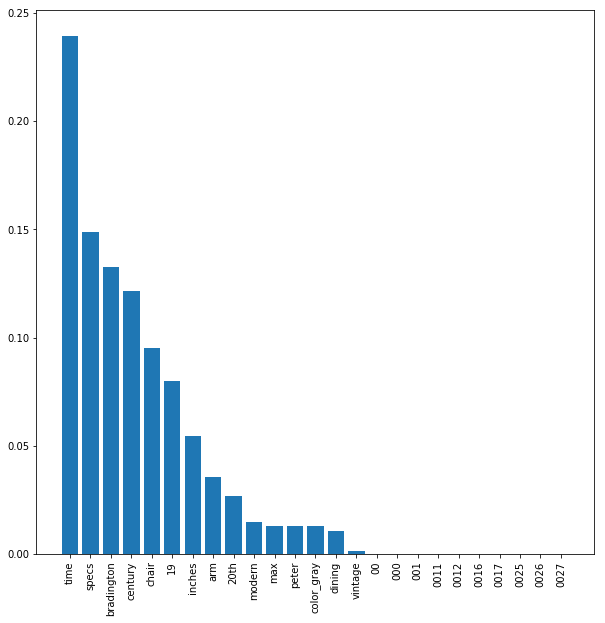


Gothic_style Too small. Only 1 items classified as Gothic_style training set

Asian_style
[[8818   14]
 [1378  309]]
tn:  8818 fp:  14 fn:  1378 tp:  309
Precision is:  0.956656346749
Recall is:  0.183165382336
Accuracy is:  0.86766802928
                scores
chair         0.106767
vinyl         0.098760
pearl         0.096404
hemp          0.083530
ceramic       0.083373
color_white   0.076307
love          0.051813
seat          0.051813
planter       0.045533
color_brown   0.044434
color_gray    0.038782
yellow        0.035641
color_yellow  0.034856
specs         0.032972
glass         0.027634
japanese      0.018213
weave         0.011776
wall          0.011619
limited       0.010049
jardin        0.009107
chloe         0.008636
color_blue    0.007222
white         0.005966
chinese       0.004396
grass         0.002983


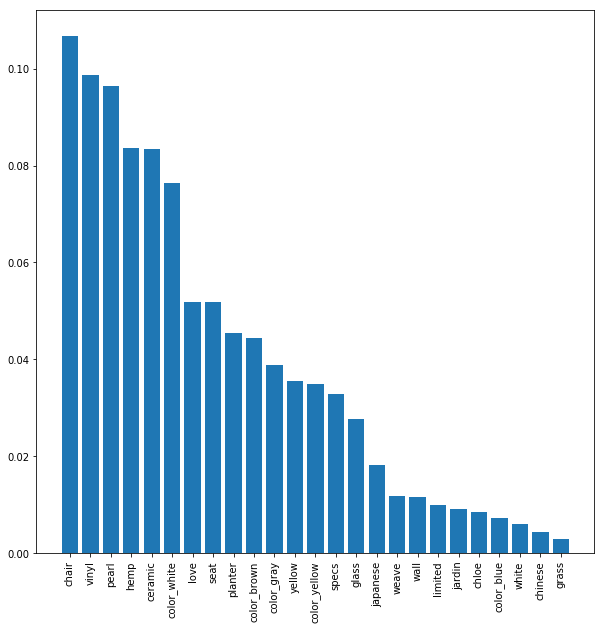


Coastal_style
[[7073  994]
 [ 630 1822]]
tn:  7073 fp:  994 fn:  630 tp:  1822
Precision is:  0.647017045455
Recall is:  0.743066884176
Accuracy is:  0.845612700827
                scores
chair         0.142857
color_white   0.142857
specs         0.112000
ceramic       0.090000
polywood      0.082286
planter       0.078143
vinyl         0.074429
butterfly     0.060571
glass         0.047571
color_yellow  0.039857
seat          0.034571
hemp          0.027571
color_brown   0.022143
color_gray    0.016000
kirar         0.011286
rush          0.006857
wide          0.003143
sofa          0.002429
tufted        0.002286
10            0.000429
depth         0.000429
inch          0.000429
outdoor       0.000429
water         0.000429
width         0.000429


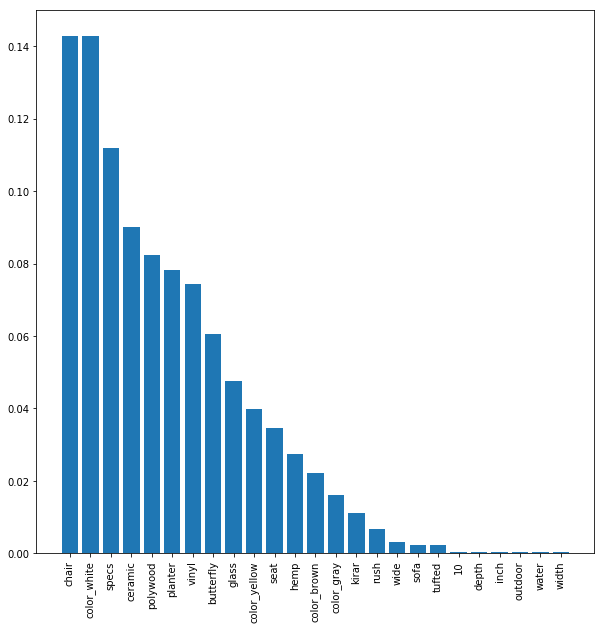


Southwestern_style Too small. Only 1 items classified as Southwestern_style training set

ArtDeco_style Too small. Only 191 items classified as ArtDeco_style training set

LouisXVI_style Too small. Only 5 items classified as LouisXVI_style training set



In [644]:
run_xgb(df,style_cols,use_cols)

In [752]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [802]:
def run_log(df,style_cols,use_cols,feature_scores):
    df_normalized = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df[use_cols])
    df_scaled = pd.DataFrame(np_scaled)
    for idx, i in enumerate(use_cols):
        df_normalized[i] = df_scaled[idx]
    
    for style_col in style_cols:
        
        filtered_df = filter_df_for_style(df_normalized,style_cols,style_col)
        tot = sum(list(filtered_df['target']))
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            feature_scores[style_col] = test_log(filtered_df,style_col,use_cols)
            print ""
    return feature_scores

def test_log(filtered_df,style_col,use_cols):
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)
    X_train, X_test, Y_train, Y_test = tts(X,y)
    log = LogisticRegression(tol=.00000001)
    log.fit(X_train,Y_train)
    print style_col
    con_matrix(log,X_test,Y_test)
    x_labels = list(labels)
    for i in use_cols:
        x_labels.append(i)
    coefs = list(log.coef_.T)
    feature_score = {i:coefs[idx] for idx,i in enumerate(x_labels)}    
    return feature_score

In [803]:
feature_scores = run_log(df,style_cols,use_cols,{})

Mid-Century_style
[[8287  190]
 [ 804 1238]]
tn:  8287 fp:  190 fn:  804 tp:  1238
Precision is:  0.866946778711
Recall is:  0.606268364349
Accuracy is:  0.905504325506

Rustic_style
[[7589  209]
 [1028 1693]]
tn:  7589 fp:  209 fn:  1028 tp:  1693
Precision is:  0.890115667718
Recall is:  0.622197721426
Accuracy is:  0.882403270273

ArtsandCrafts_style
[[9017   53]
 [ 502  947]]
tn:  9017 fp:  53 fn:  502 tp:  947
Precision is:  0.947
Recall is:  0.653554175293
Accuracy is:  0.94723833064

Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9837   27]
 [ 411  244]]
tn:  9837 fp:  27 fn:  411 tp:  244
Precision is:  0.90036900369
Recall is:  0.372519083969
Accuracy is:  0.958361060937

Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_s

In [804]:
for style in style_cols:
    try:
        counter = Counter(df[style])
        print style, counter
    except:
        print style

Mid-Century_style Counter({0: 178367, 1: 8259})
Rustic_style Counter({0: 176054, 1: 10572})
ArtsandCrafts_style Counter({0: 180770, 1: 5856})
Geometric_style Counter({0: 186609, 1: 17})
Rococo_style Counter({0: 186624, 1: 2})
FolkArt_style Counter({0: 186621, 1: 5})
Regency_style Counter({0: 183973, 1: 2653})
Neoclassical_style Counter({0: 186623, 1: 3})
Stripe_style Counter({0: 186615, 1: 11})
Floral_style Counter({0: 186625, 1: 1})
Country_style Counter({0: 186578, 1: 48})
Transitional_style Counter({0: 163478, 1: 23148})
Solid_style Counter({0: 186495, 1: 131})
Tribal_style Counter({0: 186625, 1: 1})
Traditional_style Counter({0: 167902, 1: 18724})
Victorian_style Counter({0: 186625, 1: 1})
ArtNouveau_style Counter({0: 186622, 1: 4})
HollywoodRegency_style Counter({0: 183974, 1: 2652})
Baroque_style Counter({0: 186625, 1: 1})
Woven_style Counter({0: 186625, 1: 1})
Prints_style Counter({0: 186612, 1: 14})
Industrial_style Counter({0: 175114, 1: 11512})
Classic_style Counter({0: 18661

In [805]:
for style_col in style_cols:
    print style_col
    try:
        for use_col in use_cols:
            print use_col,feature_scores[style_col][use_col]
    except:
        continue

Mid-Century_style
color_blue [-0.59919423]
color_brown [-1.02697303]
color_gray [-0.97448552]
color_purple [-0.24713478]
color_yellow [-0.36140779]
color_pink [-0.00129858]
color_green [-0.39851994]
color_teal [-0.84000887]
color_orange [-0.35410523]
color_black [ 0.44411281]
color_white [-0.92542841]
color_red [-0.37761964]
Rustic_style
color_blue [ 0.11501462]
color_brown [-0.34841583]
color_gray [ 0.15810701]
color_purple [-0.24087632]
color_yellow [-0.45307497]
color_pink [-1.88273398]
color_green [-0.28269926]
color_teal [-0.11899809]
color_orange [-2.62449441]
color_black [-0.1817057]
color_white [ 0.14255439]
color_red [-2.39888149]
ArtsandCrafts_style
color_blue [-0.63690394]
color_brown [-1.20851316]
color_gray [-0.42138639]
color_purple [-0.15788296]
color_yellow [ 0.07583707]
color_pink [-0.68540642]
color_green [ 0.16152535]
color_teal [-0.15368282]
color_orange [-0.07501428]
color_black [-1.61732501]
color_white [-2.1021242]
color_red [-2.04389929]
Geometric_style
color_bl

In [806]:
df_test = pd.DataFrame.from_dict(feature_scores)

In [807]:
df_test.loc[use_cols,:]

,ArtsandCrafts_style,Asian_style,Coastal_style,Contemporary_style,HollywoodRegency_style,Industrial_style,Mid-Century_style,Modern_style,Regency_style,Rustic_style,Traditional_style,Transitional_style
color_blue,[-0.636903940913],[-1.16116248693],[0.537710200335],[-0.771192431534],[-0.176419246654],[0.0318750533186],[-0.59919422734],[0.0393630156225],[-0.0220413708006],[0.11501462214],[-1.20459571334],[-0.986772427818]
color_brown,[-1.20851316194],[-1.18501224747],[0.996510878721],[-0.710546210626],[-1.22967592795],[-1.42492261765],[-1.02697302673],[0.341566087986],[-1.40178791176],[-0.348415832158],[0.139483058326],[-0.55643405491]
color_gray,[-0.421386390317],[-1.79498746173],[-0.0499128924922],[-0.689325263795],[0.759796131275],[-0.277419486336],[-0.97448552337],[0.367536317949],[0.760774974893],[0.158107008456],[-0.959561374773],[-0.845077429143]
color_purple,[-0.157882957747],[-0.150349168504],[0.817194640552],[0.414527758271],[-0.586814811044],[0.46576262957],[-0.247134778142],[0.275907700557],[-0.334523336474],[-0.240876315708],[-0.204367535456],[0.0291220161013]
color_yellow,[0.07583706785],[-1.00797763038],[1.22998265962],[-0.0811631678639],[1.20511979372],[-0.61929536843],[-0.361407785422],[1.52329443301],[1.38326982549],[-0.453074972451],[0.322133364952],[0.0368054640145]
color_pink,[-0.685406419997],[-0.209511272278],[0.49755949655],[-0.0920427713864],[-1.0772986509],[-1.45069140034],[-0.0012985750122],[1.43620715478],[-0.808636357548],[-1.88273398131],[-0.528451819057],[0.209401580902]
color_green,[0.161525353129],[-0.999922825583],[1.42133864895],[0.664753120468],[1.22393816027],[0.0282417402379],[-0.398519936115],[1.71453030459],[1.13165429536],[-0.282699263847],[0.0149872996681],[0.0839638245408]
color_teal,[-0.153682817118],[-1.61547831789],[1.25169150517],[0.298324224255],[0.754174485414],[0.0385595616033],[-0.840008871726],[1.25752885776],[0.614718749607],[-0.118998092238],[-0.63504343504],[0.00747720422492]
color_orange,[-0.0750142826615],[-0.851941680444],[0.834795058396],[-1.42906415858],[1.08493369192],[-1.46054516475],[-0.354105233526],[1.37948890738],[1.42710490529],[-2.62449440699],[-1.13880213801],[-1.21913981662]
color_black,[-1.6173250064],[-2.60931270394],[-0.155177179562],[-0.570909984905],[0.257700662529],[-2.7761798711],[0.444112811301],[0.85444882476],[0.0749802303397],[-0.18170569733],[-1.40476745856],[-1.31874745251]


In [808]:
num = df_test.iloc[:1,:1]

In [809]:
for col in list(df_test.columns):
    df_test[col] = [float(i) for i in df_test[col]]

In [810]:
for col in list(df_test.columns):
    print col, sum(df_test[col])

ArtsandCrafts_style 235.457015078
Asian_style 203.945941532
Coastal_style -484.514523748
Contemporary_style -590.690797033
HollywoodRegency_style -68.5762522972
Industrial_style 268.270938277
Mid-Century_style 422.974972005
Modern_style -1052.91815399
Regency_style -79.2534385377
Rustic_style 154.060206435
Traditional_style -519.555225737
Transitional_style -611.698868884


In [811]:
df_test.loc[use_cols,:].max()

ArtsandCrafts_style       0.161525
Asian_style              -0.150349
Coastal_style             3.149496
Contemporary_style        0.664753
HollywoodRegency_style    1.223938
Industrial_style          0.465763
Mid-Century_style         0.444113
Modern_style              3.663006
Regency_style             1.427105
Rustic_style              0.158107
Traditional_style         0.382932
Transitional_style        0.209402
dtype: float64

In [812]:
df_test.loc[use_cols,:].min()

ArtsandCrafts_style      -2.102124
Asian_style              -2.609313
Coastal_style            -1.746117
Contemporary_style       -1.429064
HollywoodRegency_style   -1.352350
Industrial_style         -2.867846
Mid-Century_style        -1.026973
Modern_style              0.001611
Regency_style            -1.401788
Rustic_style             -2.624494
Traditional_style        -1.489901
Transitional_style       -1.318747
dtype: float64

In [826]:
positive_words = set()
c =0
for col in list(df_test.columns):
    c+=1
    positive_words.update(list(df_test[col].nlargest(25).index))

In [827]:
print "styles: ",c
print "number of unique words out of top 25: ",len(positive_words)

styles:  12
number of unique words out of top 25:  123


In [815]:
countermax = Counter()
countermin = Counter()
for col in list(df_test.columns):
    c+=1
    countermax.update(list(df_test[col].nlargest(200).index))
    countermin.update(list(df_test[col].nsmallest(200).index))

In [825]:
countermax.most_common(100)

[(u'planter', 12),
 (u'orchids', 12),
 (u'fern', 12),
 (u'peonies', 12),
 (u'lilies', 12),
 (u'hydrangeas', 11),
 (u'succulents', 11),
 (u'vase', 10),
 (u'glass', 10),
 (u'bracket', 10),
 (u'motif', 10),
 (u'mixed', 10),
 (u'grass', 10),
 (u'stud', 9),
 (u'echeveria', 9),
 (u'finial', 9),
 (u'stem', 9),
 (u'limited', 8),
 (u'raffia', 8),
 (u'preserved', 8),
 (u'hemp', 8),
 (u'ornamental', 8),
 (u'japanese', 8),
 (u'led', 8),
 (u'plant', 8),
 (u'linen', 8),
 (u'willow', 8),
 (u'beveled', 8),
 (u'stock', 8),
 (u'linens', 8),
 (u'vinyl', 8),
 (u'discontinued', 8),
 (u'sateen', 8),
 (u'silk', 8),
 (u'weaves', 8),
 (u'suede', 8),
 (u'passing', 8),
 (u'ivy', 8),
 (u'manila', 8),
 (u'succulent', 8),
 (u'epi', 8),
 (u'orchid', 8),
 (u'ceramic', 7),
 (u'beanbag', 7),
 (u'woods', 7),
 (u'chromatic', 7),
 (u'walls', 7),
 (u'watermark', 7),
 (u'ring', 7),
 (u'fine', 7),
 (u'pole', 7),
 (u'arrowroot', 7),
 (u'grasscloth', 7),
 (u'topiary', 7),
 (u'age', 7),
 (u'tweed', 6),
 (u'basket', 6),
 (u'pape

In [824]:
countermin.most_common(100)

[(u'beach', 11),
 (u'century', 11),
 (u'palm', 11),
 (u'young', 10),
 (u'specs', 10),
 (u'upholstered', 10),
 (u'20', 10),
 (u'bradington', 10),
 (u'11', 10),
 (u'lead', 10),
 (u'time', 10),
 (u'global', 9),
 (u'yellow', 9),
 (u'products', 9),
 (u'love', 9),
 (u'pearl', 9),
 (u'views', 9),
 (u'series', 9),
 (u'oil', 9),
 (u'recliner', 9),
 (u'quadratl', 9),
 (u'seat', 9),
 (u'dragon', 9),
 (u'artificial', 9),
 (u'painted', 9),
 (u'hand', 9),
 (u'recycled', 9),
 (u'chairs', 9),
 (u'50', 9),
 (u'buddha', 9),
 (u'indoor', 9),
 (u'topiaries', 9),
 (u'inches', 9),
 (u'vi', 8),
 (u'kentia', 8),
 (u'study', 8),
 (u'rustic', 8),
 (u'iii', 8),
 (u'mc', 8),
 (u'24', 8),
 (u'looking', 8),
 (u'ceiling', 8),
 (u'slipcovered', 8),
 (u'steel', 8),
 (u'12', 8),
 (u'casual', 8),
 (u'sleeper', 8),
 (u'watercolor', 8),
 (u'cor', 8),
 (u'height', 8),
 (u'glider', 8),
 (u'rope', 8),
 (u'iv', 8),
 (u'ii', 8),
 (u'stripe', 8),
 (u'furniture', 8),
 (u'sofa', 8),
 (u'stationary', 8),
 (u'sketch', 8),
 (u'felt'

In [818]:
union = Counter()
union.update(countermin)
union.update(countermax)

In [823]:
union.most_common(1000)

[(u'japanese', 12),
 (u'mc', 12),
 (u'beach', 12),
 (u'series', 12),
 (u'quadratl', 12),
 (u'artificial', 12),
 (u'iv', 12),
 (u'ii', 12),
 (u'50', 12),
 (u'raffia', 12),
 (u'fern', 12),
 (u'lilies', 12),
 (u'time', 12),
 (u'vinyl', 12),
 (u'orchids', 12),
 (u'manila', 12),
 (u'recycled', 12),
 (u'peonies', 12),
 (u'hemp', 12),
 (u'vi', 12),
 (u'oil', 12),
 (u'linens', 12),
 (u'silk', 12),
 (u'weaves', 12),
 (u'suede', 12),
 (u'century', 12),
 (u'palm', 12),
 (u'young', 12),
 (u'iii', 12),
 (u'stock', 12),
 (u'bradington', 12),
 (u'planter', 12),
 (u'watercolor', 12),
 (u'painted', 12),
 (u'lead', 12),
 (u'yellow', 11),
 (u'slipcovered', 11),
 (u'specs', 11),
 (u'study', 11),
 (u'sleeper', 11),
 (u'recliner', 11),
 (u'epi', 11),
 (u'love', 11),
 (u'seat', 11),
 (u'felt', 11),
 (u'pearl', 11),
 (u'fine', 11),
 (u'stripe', 11),
 (u'grasscloth', 11),
 (u'sketch', 11),
 (u'topiaries', 11),
 (u'hydrangeas', 11),
 (u'beveled', 11),
 (u'watermark', 11),
 (u'succulents', 11),
 (u'chairs', 11),

### using support vector machine

In [855]:
from sklearn import svm

In [859]:
def run_svc(df,style_cols,use_cols):
    for style_col in style_cols:
        filtered_df = filter_df_for_style(df,style_cols,style_col)
        tot = sum(list(filtered_df['target']))
        if tot < 1000:
            print style_col, "Too small. Only {} items classified as {} training set".format(tot,style_col)
            print ""
        else:
            test_svc(filtered_df,style_col,use_cols)
            print ""

def test_svc(filtered_df,style_col,use_cols):
    X,y,labels = df_for_fit(filtered_df,style_col,use_cols)
    X_train, X_test, Y_train, Y_test = tts(X,y)
    svc = svm.SVC(kernel='rbf',C=1)
    svc.fit(X_train,Y_train)
    print style_col
    con_matrix(svc,X_test,Y_test)
#     graph_it(svc,labels,use_cols)

In [860]:
run_svc(df,style_cols,use_cols)

Mid-Century_style
[[8390    0]
 [2129    0]]
tn:  8390 fp:  0 fn:  2129 tp:  0
Precision is:  nan
Recall is:  0.0
Accuracy is:  0.797604335013



/home/brent/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in divide


Rustic_style
[[7863    0]
 [2656    0]]
tn:  7863 fp:  0 fn:  2656 tp:  0
Precision is:  nan
Recall is:  0.0
Accuracy is:  0.747504515638

ArtsandCrafts_style
[[9019   80]
 [1275  145]]
tn:  9019 fp:  80 fn:  1275 tp:  145
Precision is:  0.644444444444
Recall is:  0.102112676056
Accuracy is:  0.871185473904

Geometric_style Too small. Only 17 items classified as Geometric_style training set

Rococo_style Too small. Only 2 items classified as Rococo_style training set

FolkArt_style Too small. Only 5 items classified as FolkArt_style training set

Regency_style
[[9897    0]
 [ 622    0]]
tn:  9897 fp:  0 fn:  622 tp:  0
Precision is:  nan
Recall is:  0.0
Accuracy is:  0.940868903888

Neoclassical_style Too small. Only 3 items classified as Neoclassical_style training set

Stripe_style Too small. Only 11 items classified as Stripe_style training set

Floral_style Too small. Only 1 items classified as Floral_style training set

Country_style Too small. Only 48 items classified as Country_

In [862]:
check = df["showrooms"]
col = []
for idx,i in enumerate(check):
    if i in [[],np.nan]:
        col.append(0)
    else:
        lst = []
        for group in i:
            lst.append("id_{}".format(group["id"]))
        col.append(lst)
df['showroom_ids'] = col


showrm_ids = set()

check = df['showroom_ids']
c=0
for showroom_ids in check:
    if showroom_ids == 0:
        c+=1
        continue
    else:
        for i in showroom_ids:
            showrm_ids.add(i)

for i in list(showrm_ids):
    col = []
    for idx in check:
        if idx == 0:
            col.append(0)
        elif i in idx:
            col.append(1)
        else:
            col.append(0)
    df[i] = col

for i in list(df.columns):
    if "id_" in i:
        use_col.append(i)

KeyError: 'showrooms'